# Prelim

In [1]:
#check memory available for use

# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=517b67f8931882d0468bf05567c31940fbd7cac3d4d37f8c974a84bdeef2e824
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 26.4 GB  | Proc size: 159.6 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [2]:
#download required dependencies 
!pip install geopandas
!pip install netCDF4
!pip install minisom

     |████████████████████████████████| 931kB 2.8MB/s 
     |████████████████████████████████| 10.4MB 14.5MB/s 
     |████████████████████████████████| 14.7MB 206kB/s 
     |████████████████████████████████| 4.1MB 2.8MB/s 
     |████████████████████████████████| 337kB 31.5MB/s 
  Created wheel for minisom: filename=MiniSom-2.2.3-cp36-none-any.whl size=7550 sha256=d9381a5861b0850906fb0c377cb6ffdfbadab1872cdcfd9b13b08ce240596049
  Stored in directory: /root/.cache/pip/wheels/35/62/79/4d921062c847ee15a3bb3ac2ea984ed401c8b6b2944f08f697
Successfully built minisom


In [4]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
#load in functions required and dependencies to use them
#%run all_functions.ipynb
%tensorflow_version 2.x
import tensorflow
import tensorflow.keras
from tensorflow.keras import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, TimeDistributed, LSTM, Dense, Dropout, Softmax, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import geopandas as gpd
import pickle
from netCDF4 import Dataset
import minisom
from sklearn.cluster import KMeans
from scipy import interpolate
import time
import seaborn as sns
from matplotlib import cm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
prov = 'BC'
yearType = 3

if prov == 'BC':
  if yearType == 3:
    flowpickle = 'BCActNat30_flowvars.pickle'
  elif yearType == 2:
    flowpickle = 'BCActNat40_flowvars_1979.pickle'
elif prov == 'AB':
  flowpickle = 'flowDict.pickle'

In [0]:
#define functions that we'll use

def nse(y_obs, y_model):

  """
  NSE = nse(y_obs, y_model)

  y_obs, y_model --> these are arrays of the same length (1 x N or N x1) where N is the number of observations in time
  """

  y_model = y_model.reshape((-1,1))
  y_obs = y_obs.reshape((-1,1))
  nse = 1 - np.sum((y_model - y_obs)**2) / np.sum((y_obs - np.mean(y_obs))**2)
  return nse

def nse_rolling(y_obs, y_model, window, stride = 1):

  """
  NSE_rolling = nse_rolling(y_obs, y_model, window, stride)

  y_obs, y_model --> these are arrays of the same length (1 x N or N x 1) where N is the number of observations in time
  window --> this is the length of time over which to compute NSE, which will roll accross the total time period
  stride --> default stride = 1; length of step to take when rolling (i.e. stride = 365 computes yearly NSE with no overlap)
  """

  NSE_rolling = []

  y_model = y_model.reshape((-1,1))
  y_obs = y_obs.reshape((-1,1))

  startInds = range(0, len(y_model) - window, stride)
  for startInd in startInds:
    y_model_window = y_model[startInd:startInd+window] 
    y_obs_window = y_obs[startInd:startInd+window]
    NSE = nse(y_obs_window, y_model_window)
    NSE_rolling.append(NSE)

  return NSE_rolling

def plot_AB(prov='AB'):

    """
    plot borders of alberta
    
    example:
    import geopandas as gpd
    import matplotlib.pyplot as plt
    plot_AB()
    plt.show()
    """
    
    provIndex=0
    provshapes_filename = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/PROVINCE.SHP'
    provshapes = gpd.read_file(provshapes_filename)
    provPoly = provshapes['geometry'][provIndex]
    lonBorder,latBorder = provPoly.exterior.coords.xy 

    plt.plot(lonBorder,latBorder,'k')

def plot_prov(prov='AB'):

    """
    plot borders of alberta
    
    example:
    import geopandas as gpd
    import matplotlib.pyplot as plt
    plot_AB()
    plt.show()
    """
    
    if prov == 'AB':
      provIndex=0
    elif prov == 'BC':
      provIndex = 11
    provshapes_filename = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/PROVINCE.SHP'
    provshapes = gpd.read_file(provshapes_filename)
    provPoly = provshapes['geometry'][provIndex]

    if len(np.shape(provPoly)) == 0: #if only one polygon to plot

      lonBorder,latBorder = provPoly.exterior.coords.xy 
      plt.plot(lonBorder,latBorder,'k')

    else: #if multiply polygons in shape to plot

      for ind in range(len(provPoly)):

        lonBorder_segment,latBorder_segment = provPoly[ind].exterior.coords.xy 
        plt.plot(lonBorder_segment,latBorder_segment,'k')

def rmse(target,prediction):
  """ RMSE = rmse(target,prediction) """

  return(np.sqrt(((target.reshape(-1,1) - prediction.reshape(-1,1))**2).sum()/len(target.reshape(-1,1))))

def rmse_group(*args):
  rmse_group = []
  for arg in args:
    for other_arg in args:
      rmse_group.append(rmse(arg,other_arg))

  rmse_group = np.mean(rmse_group)

  return rmse_group

import tensorflow.keras.backend as K
def custom_loss(y_actual, y_predicted):
  loss = K.mean(K.abs((y_actual - y_predicted)**2))
  return loss

def custom_loss(y_actual, y_predicted):
  loss = K.mean(K.abs((y_actual - y_predicted)**2)) * K.abs(K.log(K.std(y_actual)))
  return loss


# Train CNN-LSTM

In [0]:
#load data

colabDataPath = '/content/drive/My Drive/Colab Notebooks/T_P_F_pca_lstm/'

#pickle_in = open(colabDataPath + 'flowDict.pickle','rb')
pickle_in = open(colabDataPath + flowpickle,'rb')
flowDict = pickle.load(pickle_in)

pickle_in = open(colabDataPath + 'tempDict.pickle','rb')
tempDict = pickle.load(pickle_in)

pickle_in = open(colabDataPath + 'precDict.pickle','rb')
precDict = pickle.load(pickle_in)

pickle_in = open(colabDataPath + 'relHDict.pickle','rb')
relHDict = pickle.load(pickle_in)

pickle_in = open(colabDataPath + 'ssrdDict.pickle','rb')
ssrdDict = pickle.load(pickle_in)

In [0]:
#unpack data

stationLat = flowDict['stationLat']
stationLon = flowDict['stationLon']
eraLat = tempDict['latERA']
eraLon = tempDict['lonERA']

flowDays = flowDict['windowDays']
flowMonths = flowDict['windowMonths']
flowYears = flowDict['windowYears']
eraDays = tempDict['daysERA']
eraMonths = tempDict['monthsERA']
eraYears = tempDict['yearsERA']

F = flowDict['all_flowwindow_norm_NF'] #normalized discharge with nans filled (NF)
T = tempDict['T']
Tmax = tempDict['Tmax']
Tmin = tempDict['Tmin']
P = precDict['P']
H = relHDict['H']
S = ssrdDict['S']

x_lat = np.empty((len(eraLat),len(eraLon)))
kk = 0
for lat in eraLat:
    x_lat[kk,:] = lat
    kk+=1
    
x_lon = np.empty((len(eraLat),len(eraLon)))
kk = 0
for lon in eraLon:
    x_lon[:,kk] = lon
    kk+=1

In [0]:
del precDict, tempDict, ssrdDict, relHDict

In [0]:
#set nan values to mean values of field (ie: out of province values

meanT = np.nanmean(T)
meanTmax = np.nanmean(Tmax)
meanTmin = np.nanmean(Tmin)
meanP = np.nanmean(P)
meanH = np.nanmean(H)
meanS = np.nanmean(S)
meanLat = np.nanmean(x_lat)
meanLon = np.nanmean(x_lon)

Tall = np.copy(T)
Tall[np.where(np.isnan(Tall))] = np.nanmean(T)
T = Tall

Tmaxall = np.copy(Tmax)
Tmaxall[np.where(np.isnan(Tmaxall))] = np.nanmean(Tmax)
Tmax = Tmaxall

Tminall = np.copy(Tmin)
Tminall[np.where(np.isnan(Tminall))] = np.nanmean(Tmin)
Tmin = Tminall

Pall = np.copy(P)
Pall[np.where(np.isnan(Pall))] = np.nanmean(P)
P = Pall

Hall = np.copy(H)
Hall[np.where(np.isnan(Hall))] = np.nanmean(H)
H = Hall

Sall = np.copy(S)
Sall[np.where(np.isnan(Sall))] = np.nanmean(S)
S = Sall

x_lat_all = np.copy(x_lat)
x_lat_all[np.where(np.isnan(x_lat_all))] = np.nanmean(x_lat)
x_lat = x_lat_all

x_lon_all = np.copy(x_lon)
x_lon_all[np.where(np.isnan(x_lon_all))] = np.nanmean(x_lon)
x_lon = x_lon_all

In [0]:
#select subset of stations?

customStations = 1

if customStations:

  stationInds = np.array([18,19,34,35,59,60,61,64,69,102,103,104,106,107,127,150,163,176]) - 1
  stationInds = np.array([1,2,3,9,13,26,27,41,49,62,68,76,77,78,86,120,130,131,132,134,167,18,19,34,35,59,60,61,64,69,102,103,104,106,107,127,150,163,176])-1 #these are the stations with a record > 90 years, mean flow > 1 m^3/s
  #stationInds = np.array([2,13,27,41,62,78,86,120,131,132,134,167,19,35,59,60,61,64,102,103,106,107,127,150,163,176]) - 1 #these are the stations with a record > 90 years, mean flow > 1 m^3/s, fewest nans
  #stationInds = np.array([2,13,27,62,86,120,132,134,167,19,35,59,60,64,102,103,106,107,127,150,163,176]) - 1 #these are the stations with a record > 90 years, mean flow > 1 m^3/s, fewest nans, and don't have a min flow close to zero
  #stationInds = np.array([19,35,59,60,64,102,103,106,107,127,150,163,176]) - 1 #these are the stations with a record > 90 years, mean flow > 1 m^3/s, fewest nans, and don't have a min flow close to zero
  #stationInds = np.array([19,35,59,60,64,102,103,106,107,127,163,176]) - 1 #these are the stations with a record > 90 years, mean flow > 1 m^3/s, fewest nans, and don't have a min flow close to zero
  
  #stationInds = np.array([2,9,13,26,27,29,31,36,42,43,45,50,54,56,58,77,80,81,84,85,93,94,97,101,102,109,112,122,130,131,141,143,160,210,216]) - 1 #BC
  stationInds = np.array([2,9,13,26,27,29,31,36,42,43,45,50,54,56,58,77,80,81,84,85,93,94,97,101,102,109,112,122,130,131,141,143,160,210,216, 61, 71, 72, 203]) - 1 #BC with rainy stations
  stationInds = np.array([9,13,29,31,36,42,43,45,50,54,56,58,77,80,81,84,85,93,94,97,101,102,109,112,122,130,131,141,143,160, 61, 71, 72, 203]) - 1 #BC with rainy stations (south only)
 
  #stationInds = np.array([1,2,8,9,11,15,17,22,23,25,30,34,48,50,51,54,55,60,61,64,67,68,75,76,81,84,90,91,99,101,116,128,153,157,161]) - 1 #BC with longer data record (ActNat40), meanflow > 75m3/s

  F = np.asarray(F)
  F = np.transpose(np.squeeze(F[stationInds]))

else:

  stationInds = np.arange(0,194,1)
  F = np.asarray(np.transpose(np.squeeze(F[indStartFlow:])))

In [0]:
#smooth the flow?

smoothFlow = 0

window = 30
Fnew = np.empty(np.shape(F))

if smoothFlow:

  for kk in range(len(stationInds)):

    f = pd.Series(data = F[:,kk])
    froll = f.rolling(window = window, min_periods = 1).mean()
    Fnew[:,kk] = froll.get_values()

  F = Fnew

In [0]:
#make data have same time range
startYear = max(int(np.min(eraYears)),int(np.min(flowYears)))

indStartERA = min(np.argwhere(eraYears==startYear))[0]
indStartFlow = min(np.argwhere(flowYears==startYear))[0]

#F = np.asarray(np.transpose(np.squeeze(F[indStartFlow:])))
T = np.asarray(T[indStartERA:])
Tmax = np.asarray(Tmax[indStartERA:])
Tmin = np.asarray(Tmin[indStartERA:])
P = np.asarray(P[indStartERA:])
H = np.asarray(H[indStartERA:])
S = np.asarray(S[indStartERA:])

#just alberta

if prov == 'AB':
  T = T[:,:15,29:]
  Tmax = Tmax[:,:15,29:]
  Tmin = Tmin[:,:15,29:]
  P = P[:,:15,29:]
  H = H[:,:15,28:]
  S = S[:,:15,28:]
  x_lat = x_lat[:15,29:] * np.ones(np.shape(T))
  x_lon = x_lon[:15,29:] * np.ones(np.shape(T))
  extentERA = [eraLon[28],eraLon[-1],eraLat[15],eraLat[0]]
  eraLon = eraLon[28:]
  eraLat = eraLat[:15]
elif prov == 'BC':
  T = T[:,5:15,12:37]
  Tmax = Tmax[:,5:15,12:37]
  Tmin = Tmin[:,5:15,12:37]
  P = P[:,5:15,12:37]
  H = H[:,5:15,12:37]
  S = S[:,5:15,12:37]
  x_lat = x_lat[5:15,12:37] * np.ones(np.shape(T))
  x_lon = x_lon[5:15,12:37] * np.ones(np.shape(T))
  extentERA = [eraLon[12],eraLon[37],eraLat[15],eraLat[5]]
  eraLon = eraLon[12:37]
  eraLat = eraLat[5:15]

flowDays = flowDays[indStartFlow:]
flowMonths = flowMonths[indStartFlow:]
flowYears = flowYears[indStartFlow:]

eraDays = eraDays[indStartERA:]
eraMonths = eraMonths[indStartERA:]
eraYears = eraYears[indStartERA:]

In [133]:
print(np.shape(F),np.shape(T),np.shape(Tmax), np.shape(Tmin), np.shape(P),np.shape(H),np.shape(S), np.shape(x_lat), np.shape(x_lon))

(8766, 34) (8766, 10, 25) (8766, 10, 25) (8766, 10, 25) (8766, 10, 25) (8766, 10, 25) (8766, 10, 25) (8766, 10, 25) (8766, 10, 25)


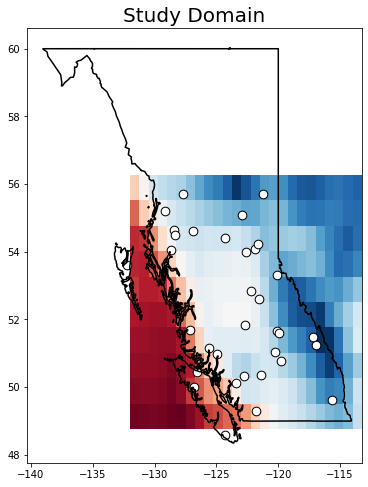

In [134]:
#plot stations in context

plt.figure(figsize = (6,8))
plot_prov(prov = prov)
plt.imshow(T[0],aspect='auto',extent = extentERA, cmap = 'RdBu_r')
plt.scatter(stationLon[stationInds],stationLat[stationInds], facecolor = 'w', edgecolor = 'k', s = 75)
plt.title('Study Domain',fontsize = 20)

plt.show()

In [0]:
#create binary precip variable

P_binary = np.zeros(np.shape(P))
for inds in np.argwhere(P>0): #anywhere there's non-zero precipitation
  P_binary[inds[0],inds[1],inds[2]] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


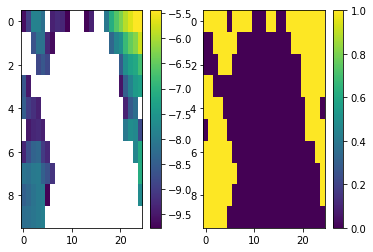

In [136]:
ind = 2000
plt.subplot(1,2,1)
plt.imshow(np.log(P[ind,:,:]),aspect = 'auto')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(P_binary[ind,:,:],aspect = 'auto')
plt.colorbar()

In [0]:
#prep data: standardize

Pnorm_usual = 0

#indices of testing/training
trainStartYear = 1987
trainFinYear = 2005
testStartYear = 2006
testFinYear = 2010

trainInds = np.squeeze(np.argwhere((flowYears>=trainStartYear) & (flowYears<=trainFinYear)))
testInds = np.squeeze(np.argwhere((flowYears>=testStartYear) & (flowYears<=testFinYear)))

#standardize variables individually (normalize wrt training period), then save as 32-bit rather than 64-bit for space
Tmean_train = np.mean([T[trainInds[ii]] for ii in range(len(trainInds))])
Tstd_train = np.std([T[trainInds[ii]] for ii in range(len(trainInds))])
Tnorm = (T - Tmean_train)/Tstd_train
Tnorm = np.single(Tnorm)

Tmaxmean_train = np.mean([Tmax[trainInds[ii]] for ii in range(len(trainInds))])
Tmaxstd_train = np.std([Tmax[trainInds[ii]] for ii in range(len(trainInds))])
Tmaxnorm = (Tmax - Tmaxmean_train)/Tmaxstd_train
Tmaxnorm = np.single(Tmaxnorm)

Tminmean_train = np.mean([Tmin[trainInds[ii]] for ii in range(len(trainInds))])
Tminstd_train = np.std([Tmin[trainInds[ii]] for ii in range(len(trainInds))])
Tminnorm = (Tmin - Tminmean_train)/Tminstd_train
Tminnorm = np.single(Tminnorm)

if Pnorm_usual:
  Pmean_train = np.mean([P[trainInds[ii]] for ii in range(len(trainInds))])
  Pstd_train = np.std([P[trainInds[ii]] for ii in range(len(trainInds))])
  Pnorm = (P - Pmean_train)/Pstd_train
  Pnorm = np.single(Pnorm)
else:
  Pstd_train = np.std([P[trainInds[ii]] for ii in range(len(trainInds))])
  Pnorm = P/Pstd_train
  Pnorm = np.power(Pnorm,1/3)
  Pnorm = np.single(Pnorm)

P_binary_mean_train = np.mean([P_binary[trainInds[ii]] for ii in range(len(trainInds))])
P_binary_std_train = np.std([P_binary[trainInds[ii]] for ii in range(len(trainInds))])
P_binary_norm = (P_binary - P_binary_mean_train)/P_binary_std_train
P_binary_norm = np.single(P_binary_norm)

Hmean_train = np.mean([H[trainInds[ii]] for ii in range(len(trainInds))])
Hstd_train = np.std([H[trainInds[ii]] for ii in range(len(trainInds))])
Hnorm = (H - Hmean_train)/Hstd_train
Hnorm = np.single(Hnorm)

Smean_train = np.mean([S[trainInds[ii]] for ii in range(len(trainInds))])
Sstd_train = np.std([S[trainInds[ii]] for ii in range(len(trainInds))])
Snorm = (S - Smean_train)/Sstd_train
Snorm = np.single(Snorm)

x_lat_mean_train = np.mean([x_lat[trainInds[ii]] for ii in range(len(trainInds))])
x_lat_std_train = np.std([x_lat[trainInds[ii]] for ii in range(len(trainInds))])
x_lat_norm = (x_lat - x_lat_mean_train)/x_lat_std_train
x_lat_norm = np.single(x_lat_norm)

x_lon_mean_train = np.mean([x_lon[trainInds[ii]] for ii in range(len(trainInds))])
x_lon_std_train = np.std([x_lon[trainInds[ii]] for ii in range(len(trainInds))])
x_lon_norm = (x_lon - x_lon_mean_train)/x_lon_std_train
x_lon_norm = np.single(x_lon_norm)

##Fmean_train = np.nanmean([F[ii][trainInds[366:]] for ii in range(len(F))])
##Fstd_train = np.nanstd([F[ii][trainInds[366:]] for ii in range(len(F))])
#Fmean_train = np.mean(F[trainInds[366:],:])
#Fstd_train = np.std(F[trainInds[366:],:])
#Fnorm = (F - Fmean_train)/Fstd_train
#Fnorm = np.single(Fnorm)

In [0]:
#normalize flow

Fnorm = np.empty_like(F)
for station in range(np.shape(F)[1]):
    #Fnorm[:,station] = (F[:,station] - np.mean(F[:,station]))/np.std(F[:,station])
    minF = np.min(F[:,station])
    maxF = 2 * np.std(F[:,station])
    Fnorm[:,station] = (F[:,station] - minF) / (maxF - minF)
    
#for inds in np.argwhere(F>10):
#  F[inds[0],inds[1]] = 10

In [0]:
#construct transfer learning on binary precip data

stationPbinary = np.zeros((len(eraDays),len(stationInds)))
stationP = np.zeros((len(eraDays),len(stationInds)))
for station in range(np.shape(F)[1]): #for each station, find nearest grid cell 

  dlat = np.min(np.abs(stationLat[stationInds[station]] - eraLat))
  indLat = np.argwhere(np.abs(stationLat[stationInds[station]] - eraLat) == dlat)[0]
  dlon = np.min(np.abs(stationLon[stationInds[station]] - eraLon))
  indLon = np.argwhere(np.abs(stationLon[stationInds[station]] - eraLon) == dlon)[0]

  #dlat = np.min(np.abs(stationLat[kk] - eraLat))
  #indLat = np.argwhere(np.abs(stationLat[kk] - eraLat) == dlat)[0]
  #dlon = np.min(np.abs(stationLon[kk] - eraLon))
  #indLon = np.argwhere(np.abs(stationLon[kk] - eraLon) == dlon)[0]

  stationPbinary[:,station] = np.squeeze(P_binary[:,indLat,indLon])
  stationP[:,station] = np.squeeze(Pnorm[:,indLat,indLon])

y_transfer_train = np.squeeze([stationPbinary[365:trainInds[-1]+1,ii] for ii in range(np.shape(F)[1])]).T
y_transfer_test = np.squeeze([stationPbinary[testInds,ii] for ii in range(np.shape(F)[1])]).T

y_transfer_train = np.squeeze([stationP[365:trainInds[-1]+1,ii] for ii in range(np.shape(F)[1])]).T
y_transfer_test = np.squeeze([stationP[testInds,ii] for ii in range(np.shape(F)[1])]).T



In [0]:
#construct train and test predictor/target tensors

#target data
y_train = np.squeeze([Fnorm[365:trainInds[-1]+1,ii] for ii in range(np.shape(F)[1])]).T
y_test = np.squeeze([Fnorm[testInds,ii] for ii in range(np.shape(F)[1])]).T
y = np.empty((len(y_train[:,0])+len(y_test[:,0]),np.shape(F)[1])).T
y[:,:len(y_train[:,0])] = y_train.T
y[:,len(y_train[:,0]):] = y_test.T
y = y.T
y_train = y_train.astype(dtype = np.float16)
y_test = y_test.astype(dtype = np.float16)
y = y.astype(dtype = np.float16)

#first, make (n_time x n_lon x n_lat x n_vars) tensor 
#x_intermediate = np.zeros((8766,17,43,2))
nchannels = 3
x_intermediate = np.empty(np.shape(Tmaxnorm) + (nchannels,),dtype='single')
x_intermediate[:,:,:,0] = Tmaxnorm
x_intermediate[:,:,:,1] = Tminnorm
x_intermediate[:,:,:,2] = Pnorm
#x_intermediate[:,:,:,3] = P_binary_norm
#x_intermediate[:,:,:,3] = Hnorm
#x_intermediate[:,:,:,4] = Snorm
#x_intermediate[:,:,:,3] = x_lat_norm
#x_intermediate[:,:,:,4] = x_lon_norm
x_train_intermediate = x_intermediate[trainInds]
x_test_intermediate = x_intermediate[testInds]

In [0]:
dfdt = np.zeros(np.shape(y))
dfdt[1:,:] = y[1:,:] - y[:-1,:]
dfdt_mean = np.mean(dfdt[trainInds,:])
dfdt_std = np.std(dfdt[trainInds,:])

dfdt_norm = (dfdt - dfdt_mean) / dfdt_std

ntrain = len(y_train)
dfdt_train = dfdt_norm[:ntrain]
dfdt_test = dfdt_norm[ntrain:]


In [142]:
np.shape(y), np.shape(y_test), np.shape(y_train)

((8401, 34), (1826, 34), (6575, 34))

In [0]:
y_train_dfdt = np.zeros((np.shape(y_train)[0],2*np.shape(y_train)[1]))
y_train_dfdt[:,:np.shape(y_train)[1]] = y_train
y_train_dfdt[:,np.shape(y_train)[1]:] = dfdt_train

y_test_dfdt = np.zeros((np.shape(y_test)[0],2*np.shape(y_test)[1]))
y_test_dfdt[:,:np.shape(y_test)[1]] = y_test
y_test_dfdt[:,np.shape(y_test)[1]:] = dfdt_test

In [0]:
y_transfer_train = np.zeros(np.shape(y_train))
y_transfer_train[1:,:] = y_train[1:,:] - y_train[:-1,:]

y_transfer_test = np.zeros(np.shape(y_test))
y_transfer_test[1:,:] = y_test[1:,:] - y_test[:-1,:]

ind = 16
y_transfer_train = y_train[:,16]
y_transfer_test = y_test[:,16]

#y_train_dfdt = np.zeros((np.shape(y_train)[0],2*np.shape(y_train)[1]))
#y_train_dfdt[:,:np.shape(y_train)[1]] = y_train
#y_train_dfdt[1:,np.shape(y_train)[1]:] = y_train[1:,:] - y_train[:-1,:]
#y_train_dfdt[:,np.shape(y_train)[1]:] = y_train_dfdt[:,np.shape(y_train)[1]:] / np.std(y_train)
#
#y_test_dfdt = np.zeros((np.shape(y_test)[0],2*np.shape(y_test)[1]))
#y_test_dfdt[:,:np.shape(y_test)[1]] = y_test
#y_test_dfdt[1:,np.shape(y_test)[1]:] = y_test[1:,:] - y_test[:-1,:]
#y_test_dfdt[:,np.shape(y_test)[1]:] = y_test_dfdt[:,np.shape(y_test)[1]:] / np.std(y_train)

In [0]:
#now, convert x_intermediate into (n_time x 365 x n_lon x n_lat x n_vars) tensor
x = np.empty((8766-365,365,15,14,nchannels),dtype=np.float16)
x_train = np.empty((len(trainInds)-365, 365, ) + np.shape(Tmaxnorm)[1:] + (nchannels,),dtype=np.float16)
x_test = np.empty((len(testInds), 365,) + np.shape(Tmaxnorm)[1:] + (nchannels,),dtype=np.float16)

In [0]:
for ii in range(1000):
    x_train[ii] = x_intermediate[ii:ii+365]

In [0]:
for ii in range(1000,2000):
    x_train[ii] = x_intermediate[ii:ii+365]

In [0]:
for ii in range(2000,3000):
    x_train[ii] = x_intermediate[ii:ii+365]

In [0]:
for ii in range(3000,4000):
    x_train[ii] = x_intermediate[ii:ii+365]

In [0]:
for ii in range(4000,len(trainInds)-365):
    x_train[ii] = x_intermediate[ii:ii+365]

In [0]:
for ii in range(1000):
    x_test[ii] = x_intermediate[ii+len(trainInds)-365:ii+len(trainInds)]

In [0]:
for ii in range(1000,len(testInds)):
    x_test[ii] = x_intermediate[ii+len(trainInds)-365:ii+len(trainInds)]

In [0]:
#shift predictions to be one day earlier

day_shift = 0

if day_shift:
  shift = 1
  x = x[shift:]
  x_test = x_test[shift:]
  x_train = x_train[shift:]

  y = y[:-shift]
  y_test = y_test[:-shift]
  y_train = y_train[:-shift]

  y_test_dfdt = y_test_dfdt[:-shift]
  y_train_dfdt = y_train_dfdt[:-shift]

In [0]:
#shift predictions to be one day earlier

day_shift = 0

if day_shift:
  shift = 1
  x.pop(shift)
  x_test.pop(shift)
  x_train.pop(shift)

  y.pop(-shift)
  y_test.pop(-shift)
  y_train.pop(-shift)

  y_test_dfdt(-shift)
  y_train_dfdt(-shift)

In [0]:
#transfer learn? Build model

transferLearn_binaryP = 0

if transferLearn_binaryP:

  #build model w/ classifier at end

  learning_rate = 0.0001/100

  #CNN model
  print('Building model...')
  model = Sequential()

  model.add(TimeDistributed(
      Conv2D(filters = 8, kernel_size = (3,3), activation='relu',data_format='channels_last', padding='same'), 
      input_shape=(365,)+np.shape(Tnorm[0])+(nchannels,)))

  model.add(TimeDistributed(
      Conv2D(filters = 8, kernel_size = (3,3), activation='relu',data_format='channels_last', padding='same'), 
      input_shape=(365,)+np.shape(Tnorm[0])+(nchannels,)))

  model.add(TimeDistributed(MaxPooling2D(pool_size = 2)))

  model.add(TimeDistributed(
      Conv2D(filters = 16, kernel_size = (2,2), activation='relu',data_format='channels_last', padding='same'), 
      ))

  model.add(TimeDistributed(
      Conv2D(filters = 16, kernel_size = (2,2), activation='relu',data_format='channels_last', padding='same'), 
      ))

  model.add(TimeDistributed(MaxPooling2D(pool_size = 2)))

  model.add(TimeDistributed(Flatten()))

  model.add(Dropout(rate = 0.1))

  model.add(LSTM(40, return_sequences=True))

  model.add(Flatten())
  model.add(Dense(np.shape(F)[1], activation = 'linear'))

  #model.add(Dense(np.shape(F)[1], activation = 'sigmoid'))
  model.add(Dense(1, activation = 'linear'))

  #compile
  print('Compiling model...')
  #model.compile(loss=tensorflow.keras.losses.binary_crossentropy,
  #              optimizer=tensorflow.keras.optimizers.Adam(lr=learning_rate),
  #              metrics = ['accuracy'])
  model.compile(loss=tensorflow.keras.losses.MSE,
                optimizer=tensorflow.keras.optimizers.Adam(lr=learning_rate))
  es = EarlyStopping(monitor='val_loss', 
                    mode='min', 
                    verbose=1, 
                    patience = 3,
                    restore_best_weights = True)
  
  model.summary()

In [0]:
#transfer learn?  Train model

if transferLearn_binaryP:
  
  #fit
  batch_size = 32
  epochs = 80
  history = model.fit(
              x_train, y_transfer_train,
              validation_split = 0.2,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1, 
              callbacks = [es],
            )


In [0]:
#remove softmax layer and train model on streamflow data

if transferLearn_binaryP:

  model.pop()
  learning_rate = 0.0001/10
  model.compile(loss=tensorflow.keras.losses.MSE,
              optimizer=tensorflow.keras.optimizers.Adam(lr=learning_rate))
  model.summary()

In [0]:
if transferLearn_binaryP:

  #model.layers[-1].activation = tensorflow.keras.activations.linear

  learning_rate = 0.0001
  model.compile(loss=tensorflow.keras.losses.MSE,
              optimizer=tensorflow.keras.optimizers.Adam(lr=learning_rate))

  #fit
  batch_size = 128
  epochs = 40
  history = model.fit(
              x_train, y_train,
              validation_split = 0.2,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1, 
              callbacks = [es],
            )

In [0]:
def custom_loss(y_actual, y_predicted):
  
  SE = K.square(y_actual - y_predicted)
  SE1 = K.expand_dims(SE[:39])
  SE2 = K.expand_dims(SE[39:])

  #SE1 = K.reshape(SE1,(1, 39))
  #SE2 = K.reshape(SE2,(39, 1))

  SE1 = SE[:,:39]
  SE2 = SE[:,39:]

  loss = SE1+SE2
  loss = K.mean(loss)
  #loss = K.batch_dot(SE1,SE2)
  
  #loss = K.mean(SE1)
  #print(SE1)
  #print(SE2)
  #print(K.mean(K.dot(K.transpose(SE1),SE2)))
  #loss = K.mean(K.dot(K.transpose(SE1),SE2))

  return loss

In [0]:
def custom_loss(y_actual, y_predicted):
  
  SE = K.square(y_actual - y_predicted) * (y_actual + K.max(y_actual))

  loss = K.mean(SE)
  #loss = K.batch_dot(SE1,SE2)
  
  #loss = K.mean(SE1)
  #print(SE1)
  #print(SE2)
  #print(K.mean(K.dot(K.transpose(SE1),SE2)))
  #loss = K.mean(K.dot(K.transpose(SE1),SE2))

  return loss

In [0]:
def custom_loss(y_actual, y_predicted):
  
  l = 194

  SE = K.square(y_actual - y_predicted)
  SE1 = K.expand_dims(SE[:l])
  SE2 = K.expand_dims(SE[l:])

  #SE1 = K.reshape(SE1,(1, 39))
  #SE2 = K.reshape(SE2,(39, 1))

  SE1 = SE[:,:l]
  SE2 = SE[:,l:]

  #print(K.square(y_actual)[:,:39])

  #loss = K.std(y_actual[:,:39])*SE1+K.std(y_actual[:,39:])*SE2
  loss = SE1 + K.sqrt(SE1*SE2) + SE2
  loss = K.mean(loss)
  #loss = K.batch_dot(SE1,SE2)
  
  #loss = K.mean(SE1)
  #print(SE1)
  #print(SE2)
  #print(K.mean(K.dot(K.transpose(SE1),SE2)))
  #loss = K.mean(K.dot(K.transpose(SE1),SE2))

  return loss

In [0]:
#train to predict both flow and dfdt?

train_dfdt = 0

if train_dfdt:

  #build model

  learning_rate = 0.0001/50

  #CNN model
  print('Building model...')
  model = Sequential()

  model.add(TimeDistributed(
      Conv2D(filters = 16, kernel_size = (1,1), activation='relu',data_format='channels_last', padding='same'), 
      input_shape=(365,)+np.shape(Tnorm[0])+(nchannels,)))
  
  model.add(TimeDistributed(
      Conv2D(filters = 16, kernel_size = (1,1), activation='relu',data_format='channels_last', padding='same'), 
      input_shape=(365,)+np.shape(Tnorm[0])+(nchannels,)))

  model.add(TimeDistributed(
      Conv2D(filters = 16, kernel_size = (3,3), activation='relu',data_format='channels_last', padding='same'), 
      input_shape=(365,)+np.shape(Tnorm[0])+(nchannels,)))
  
  model.add(TimeDistributed(
      Conv2D(filters = 16, kernel_size = (3,3), activation='relu',data_format='channels_last', padding='same'), 
      input_shape=(365,)+np.shape(Tnorm[0])+(nchannels,)))

  model.add(TimeDistributed(MaxPooling2D(pool_size = 2)))

  model.add(TimeDistributed(
      Conv2D(filters = 32, kernel_size = (3,3), activation='relu',data_format='channels_last', padding='same'), 
      ))

  model.add(TimeDistributed(
      Conv2D(filters = 32, kernel_size = (3,3), activation='relu',data_format='channels_last', padding='same'), 
      ))

  model.add(TimeDistributed(MaxPooling2D(pool_size = 2)))

  model.add(TimeDistributed(Flatten()))

  model.add(Dropout(rate = 0.1))

  model.add(LSTM(40, return_sequences=True))
  #model.add(LSTM(40, return_sequences=True))

  model.add(Flatten())
  model.add(Dense(np.shape(F)[1]*2, activation = 'linear'))

  #model.add(Dense(np.shape(F)[1], activation = 'sigmoid'))

  #compile
  print('Compiling model...')
  #model.compile(loss=tensorflow.keras.losses.binary_crossentropy,
  #              optimizer=tensorflow.keras.optimizers.Adam(lr=learning_rate),
  #              metrics = ['accuracy'])
  
  model.compile(loss=tensorflow.keras.losses.MSE,
                optimizer=tensorflow.keras.optimizers.Adam(lr=learning_rate))
  
  #model.compile(loss=custom_loss,
  #              optimizer=tensorflow.keras.optimizers.Adam(lr=learning_rate))
  
  es = EarlyStopping(monitor='val_loss', 
                    mode='min', 
                    verbose=1, 
                    patience = 3,
                    restore_best_weights = True)
  
  model.summary()

In [0]:
#flow and dfdt?  Train model

if train_dfdt:
  #fit
  batch_size = 128
  epochs = 20
  history = model.fit(
              x_train, y_train_dfdt,
              validation_split = 0.2,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1, 
              callbacks = [es],
            )


In [164]:
#build model

learning_rate = 0.0001/10

#CNN model
print('Building model...')
model = Sequential()

model.add(TimeDistributed(
    Conv2D(filters = 16, kernel_size = (1,1), activation='relu',data_format='channels_last', padding='same'), 
    input_shape=(365,)+np.shape(Tnorm[0])+(nchannels,)))

model.add(TimeDistributed(
    Conv2D(filters = 16, kernel_size = (1,1), activation='relu',data_format='channels_last', padding='same'), 
    input_shape=(365,)+np.shape(Tnorm[0])+(nchannels,)))

model.add(TimeDistributed(
    Conv2D(filters = 16, kernel_size = (3,3), activation='relu',data_format='channels_last', padding='same'), 
    input_shape=(365,)+np.shape(Tnorm[0])+(nchannels,)))

model.add(TimeDistributed(
    Conv2D(filters = 16, kernel_size = (3,3), activation='relu',data_format='channels_last', padding='same'), 
    input_shape=(365,)+np.shape(Tnorm[0])+(nchannels,)))

model.add(TimeDistributed(MaxPooling2D(pool_size = 2)))

model.add(TimeDistributed(
    Conv2D(filters = 32, kernel_size = (3,3), activation='relu',data_format='channels_last', padding='same'), 
    ))

model.add(TimeDistributed(
    Conv2D(filters = 32, kernel_size = (3,3), activation='relu',data_format='channels_last', padding='same'), 
    ))

#model.add(TimeDistributed(MaxPooling2D(pool_size = 2)))

model.add(TimeDistributed(
    GlobalMaxPooling2D(data_format='channels_last')))

model.add(TimeDistributed(Flatten()))

model.add(Dropout(rate = 0.1))

#model.add(Dense(20, activation = 'relu'))

model.add(LSTM(40, return_sequences=True))
#model.add(LSTM(20, return_sequences=True))
#model.add(LSTM(20, return_sequences=True))

model.add(Flatten())
model.add(Dense(np.shape(F)[1], activation = 'linear'))
#model.add(Dense(np.shape(F)[1], activation = 'linear'))

#compile
print('Compiling model...')
model.compile(loss=tensorflow.keras.losses.MSE,
              optimizer=tensorflow.keras.optimizers.Adam(lr=learning_rate))
#model.compile(loss=custom_loss,
#              optimizer=tensorflow.keras.optimizers.Adam(lr=learning_rate))

es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=1, 
                   patience = 3,
                   restore_best_weights = True)

model.summary()

Building model...
Compiling model...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_18 (TimeDis (None, 365, 10, 25, 16)   64        
_________________________________________________________________
time_distributed_19 (TimeDis (None, 365, 10, 25, 16)   272       
_________________________________________________________________
time_distributed_20 (TimeDis (None, 365, 10, 25, 16)   2320      
_________________________________________________________________
time_distributed_21 (TimeDis (None, 365, 10, 25, 16)   2320      
_________________________________________________________________
time_distributed_22 (TimeDis (None, 365, 5, 12, 16)    0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, 365, 5, 12, 32)    4640      
_________________________________________________________________
time_distributed_

In [165]:
#fit

#model.compile(loss=tensorflow.keras.losses.MSE,
#              optimizer=tensorflow.keras.optimizers.Adam(lr=learning_rate))

batch_size = 64
epochs = 40
history = model.fit(
            x_train, y_train,
            validation_split = 0.2,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1, 
            callbacks = [es],
          )

Epoch 1/40
83/83 [==============================] - 70s 842ms/step - loss: 0.1404 - val_loss: 0.1067
Epoch 2/40
83/83 [==============================] - 68s 819ms/step - loss: 0.0818 - val_loss: 0.0680
Epoch 3/40
83/83 [==============================] - 68s 820ms/step - loss: 0.0516 - val_loss: 0.0586
Epoch 4/40
83/83 [==============================] - 68s 820ms/step - loss: 0.0470 - val_loss: 0.0572
Epoch 5/40
83/83 [==============================] - 68s 819ms/step - loss: 0.0456 - val_loss: 0.0565
Epoch 6/40
83/83 [==============================] - 68s 819ms/step - loss: 0.0446 - val_loss: 0.0560
Epoch 7/40
83/83 [==============================] - 68s 820ms/step - loss: 0.0443 - val_loss: 0.0554
Epoch 8/40
83/83 [==============================] - 68s 819ms/step - loss: 0.0434 - val_loss: 0.0547
Epoch 9/40
83/83 [==============================] - 68s 819ms/step - loss: 0.0431 - val_loss: 0.0542
Epoch 10/40
83/83 [==============================] - 68s 820ms/step - loss: 0.0421 - val_lo

In [48]:
np.shape(x_train)

(6575, 365, 15, 14, 3)

In [49]:
#fit more, different loss function

def custom_loss(y_actual, y_predicted):
  loss = K.mean(K.abs((y_actual - y_predicted)**2)) * K.abs(K.log(K.std(y_actual)))
  return loss

def custom_loss(y_actual, y_predicted):
  MSE = K.mean(K.abs((y_actual - y_predicted)**2))
  SE = (y_actual - y_predicted)**2
  loss = K.mean(K.abs((y_actual[K.greater(SE,MSE)] - y_predicted[K.greater(SE,MSE)])**2))
  return loss

model.compile(loss=custom_loss,
              optimizer=tensorflow.keras.optimizers.Adam(lr=learning_rate/10))

batch_size = 128
epochs = 40
history = model.fit(
            x_train, y_train,
            validation_split = 0.2,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1, 
            callbacks = [es],
          )

Epoch 1/40


KeyboardInterrupt: ignored

In [0]:
#save model

saveModel = 1
glacierStations = 0
num_stations = len(stationInds)

if saveModel == 1:

  if glacierStations == 1:
    modelName = str(num_stations) + '_stations_' + 'CNN_LSTM_DENSE_glacierStations_' + str(epochs) + '_epochs'
    model.save(modelName + '.h5')
  else:
    modelName = str(num_stations) + '_stations_' + 'CNN_LSTM_DENSE_' + str(epochs) + '_epochs'
    model.save(modelName + '.h5')

In [0]:
#load model

loadModel = 0

if loadModel == 1:

  dataPath = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/'

  if glacierStations == 1:
    modelName = str(num_stations) + '_stations_' + 'CNN_LSTM_DENSE_glacierStations_' + str(epochs) + '_epochs'
    model = load_model(dataPath + modelName + '.h5')
  else:
    modelName = str(num_stations) + '_stations_' + 'CNN_LSTM_DENSE_' + str(epochs) + '_epochs'
    model = load_model(dataPath + modelName + '.h5')


In [0]:
model_bulk = tensorflow.keras.models.clone_model(model)
#model_bulk.compile(loss=tensorflow.keras.losses.MSE,
#              optimizer=tensorflow.keras.optimizers.Adam(lr=learning_rate))
model_bulk.set_weights(model.get_weights())

In [0]:
trainSmallBatch = 0

if trainSmallBatch:

  #fit
  batch_size = 64
  epochs = 10
  history = model.fit(
              x_train, y_train,
              validation_split = 0.2,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1, 
              callbacks = [es],
            )

In [0]:
trainSmallLR = 0

if trainSmallLR:

  LR_reduce_factor = 10

  model.compile(loss=tensorflow.keras.losses.MSE,
              optimizer=tensorflow.keras.optimizers.Adam(
                  lr=learning_rate / LR_reduce_factor)
              )  

  #fit
  batch_size = batch_size
  epochs = 10
  history = model.fit(
              x_train, y_train,
              validation_split = 0.2,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1, 
              callbacks = [es],
            )

In [0]:
trainSmallBatch_SmallLR = 0

if trainSmallBatch_SmallLR:

  LR_reduce_factor = 10
  batch_size = 32

  model.compile(loss=tensorflow.keras.losses.MSE,
              optimizer=tensorflow.keras.optimizers.Adam(
                  lr=learning_rate / LR_reduce_factor)
              )  

  #fit
  epochs = 20
  history = model.fit(
              x_train, y_train,
              validation_split = 0.2,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1, 
              callbacks = [es],
            )

In [0]:
freezeWeights = 0

if freezeWeights:

  for layer in model.layers:
    layer.trainable = False
    #print(layer)


In [0]:
addLSTMLayer = 0

if addLSTMLayer:

  #store the post-LSTM layers
  FC= model.layers[-1]
  flat = model.layers[-2]

  #remove post-LSTM layers from model
  model.pop() #remove Dense
  model.pop() #remove flatten
  model.add(LSTM(40, return_sequences=True))
  #model.add(LSTM(20, return_sequences=True))
  #model.add(LSTM(20, return_sequences=True))
  #model.add(Dropout(rate=0.1))

  model.add(flat) 
  model.add(FC) 

  model.compile(loss=tensorflow.keras.losses.MSE,
              optimizer=tensorflow.keras.optimizers.Adam(lr=learning_rate))
  
  model.summary()
  


In [0]:
fineTuneLastLayer = 0

if fineTuneLastLayer:
  #fit
  batch_size = batch_size
  epochs = 20
  history = model.fit(
              x_train, y_train,
              validation_split = 0.2,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1, 
              callbacks = [es],
            )

In [173]:
print('Calculating predicted training values...')
y_train_predicted = model.predict(x_train, batch_size = batch_size, verbose = 1)

print('Calculating predicted testing values...')
y_test_predicted = model.predict(x_test, batch_size = batch_size, verbose = 1)

print('Calculating all predicted values...')
y_predicted = np.vstack((y_train_predicted,y_test_predicted))

Calculating predicted training values...
103/103 [==============================] - 25s 246ms/step
Calculating predicted testing values...
29/29 [==============================] - 7s 258ms/step
Calculating all predicted values...


In [0]:
if np.shape(y_test)[1]>len(stationInds):
  y_train_predicted = y_train_predicted[:,:np.shape(y_test)[1]]
  y_test_predicted = y_test_predicted[:,:np.shape(y_test)[1]]
  y_predicted = y_predicted[:,:np.shape(y_test)[1]]

In [60]:
print('Calculating predicted training values...')
y_train_predicted_bulk = model_bulk.predict(x_train, batch_size = batch_size, verbose = 1)

print('Calculating predicted testing values...')
y_test_predicted_bulk = model_bulk.predict(x_test, batch_size = batch_size, verbose = 1)

print('Calculating all predicted values...')
y_predicted_bulk = np.vstack((y_train_predicted,y_test_predicted))

Calculating predicted training values...
103/103 [==============================] - 7s 69ms/step
Calculating predicted testing values...
29/29 [==============================] - 2s 67ms/step
Calculating all predicted values...


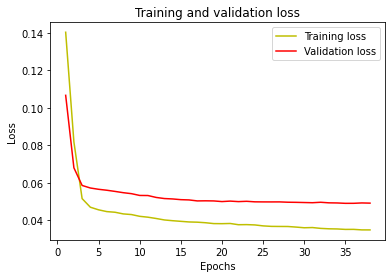

In [174]:
#visualize training loss

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

#plt.ylim((0,0.2))
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.yscale('log')
plt.legend()
plt.show()

In [244]:
predict_residuals = 1

if predict_residuals:

  y_train_res = y_train - y_train_predicted
  y_test_res = y_test - y_test_predicted

  model_res = tensorflow.keras.models.clone_model(model)
  #model_res.set_weights(model.get_weights())

  model_res.compile(loss=tensorflow.keras.losses.MSE,
              optimizer=tensorflow.keras.optimizers.Adam(lr=learning_rate))

  batch_size = 64
  epochs = 40
  history = model_res.fit(
              x_train, y_train_res,
              validation_split = 0.2,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1, 
              callbacks = [es],
            )

Epoch 1/40
83/83 [==============================] - 69s 826ms/step - loss: 0.0352 - val_loss: 0.0494
Epoch 2/40
83/83 [==============================] - 68s 820ms/step - loss: 0.0345 - val_loss: 0.0492
Epoch 3/40
83/83 [==============================] - 68s 819ms/step - loss: 0.0344 - val_loss: 0.0492
Epoch 4/40
83/83 [==============================] - 68s 819ms/step - loss: 0.0345 - val_loss: 0.0493
Epoch 5/40
83/83 [==============================] - 68s 818ms/step - loss: 0.0348 - val_loss: 0.0492
Epoch 6/40
83/83 [==============================] - 68s 819ms/step - loss: 0.0342 - val_loss: 0.0492
Epoch 00006: early stopping


In [245]:
if predict_residuals:

  print('Calculating predicted training values...')
  y_train_res_predicted = model_res.predict(x_train, batch_size = batch_size, verbose = 1)

  print('Calculating predicted testing values...')
  y_test_res_predicted = model_res.predict(x_test, batch_size = batch_size, verbose = 1)

  print('Calculating all predicted values...')
  y_res_predicted = np.vstack((y_train_predicted,y_test_predicted))

  y_train_total_predicted = y_train_predicted + y_train_res_predicted
  y_test_total_predicted = y_test_predicted + y_test_res_predicted

Calculating predicted training values...
103/103 [==============================] - 25s 238ms/step
Calculating predicted testing values...
29/29 [==============================] - 7s 230ms/step
Calculating all predicted values...


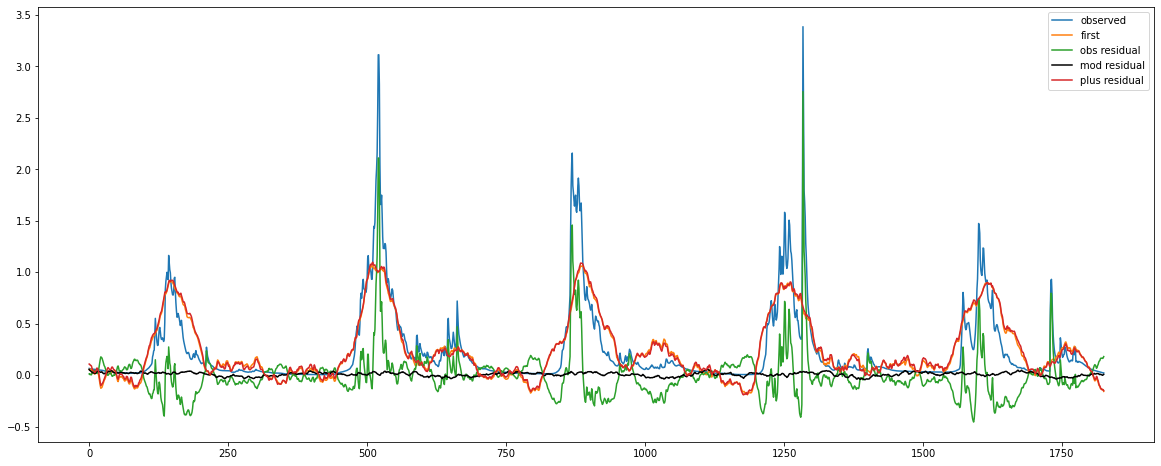

In [246]:
if predict_residuals:

  station = 1

  plt.figure(figsize = (20,8))
  plt.plot(y_test[:,station], label = 'observed')
  plt.plot(y_test_predicted[:,station], label = 'first')
  plt.plot(y_test_res[:,station], label = 'obs residual')
  plt.plot(y_test_res_predicted[:,station], color = 'k', label = 'mod residual')
  plt.plot(y_test_total_predicted[:,station], label = 'plus residual')
  plt.legend()


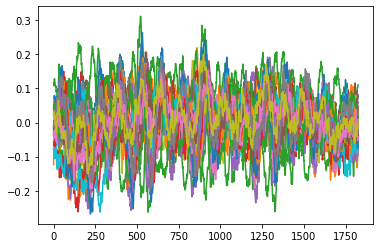

In [54]:
plt.plot(y_test_res_predicted)
plt.show()

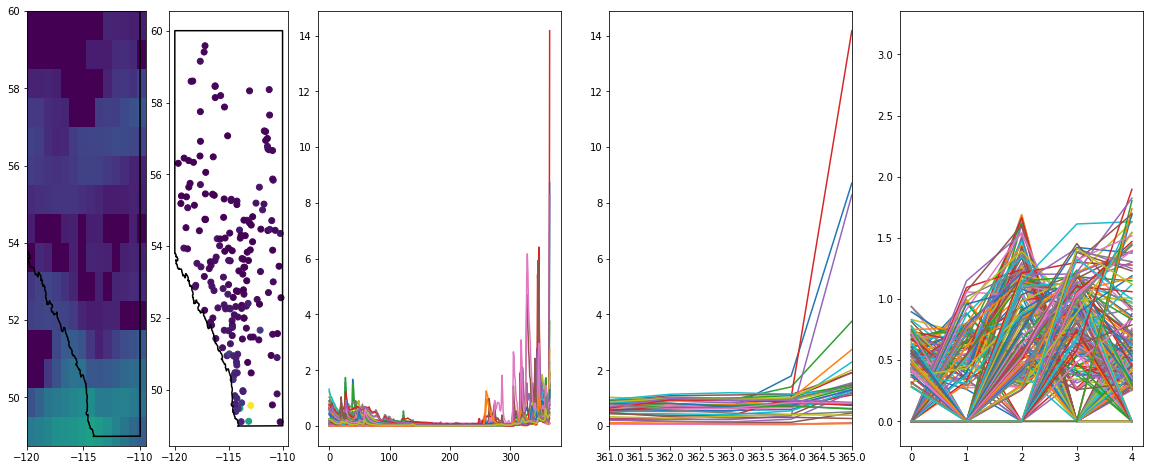

In [129]:
day = 4*365+168

plt.figure(figsize = (4*5,8))

plt.subplot(181)
vmin = np.min(Pnorm) #np.min(x_test[:,:,:,:,-1])
vmax = np.max(Pnorm) #np.max(x_test[:,:,:,:,-1])
plt.imshow(np.double(x_test[day,-1,:,:,-1]),aspect = 'auto', extent = extentERA, vmin = vmin, vmax = vmax)
plot_prov(prov = prov)

plt.subplot(182)
plt.scatter(stationLon[stationInds],stationLat[stationInds],c = y_test[day,:len(stationInds)])
plot_prov(prov = prov)

plt.subplot(142)
plt.plot(y_test[day-365:day+1,:39])

plt.subplot(143)
plt.plot(y_test[day-365:day+1,:39])
plt.xlim((361,365))

plt.subplot(144)
for jj in range(15):
  for kk in range(14):
    plt.plot(np.double(x_test[day,-5:,jj,kk,-1]))
plt.ylim((vmin-0.2,vmax))

plt.show()

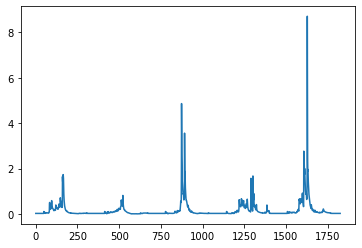

In [124]:
plt.plot(y_test[:,0])

In [46]:
np.shape(x_test)

(1826, 365, 15, 14, 3)

In [0]:
#make gif of streamflow evolution epochs
import imageio

def plot_for_offset(day,x_test,y_test,stationLon,stationLat,stationInds, prov, extentERA):
    
    vmin = np.min(Pnorm) #np.min(x_test[:,:,:,:,-1])
    vmax = np.max(Pnorm) #np.max(x_test[:,:,:,:,-1])

    #plt.subplot(141)
    #plt.imshow(np.double(x_test[day,-1,:,:,-1]),aspect = 'auto', extent = extentERA, vmin = vmin, vmax = vmax)
    #plot_prov(prov = prov)

    #plt.subplot(142)
    #plt.scatter(stationLon[stationInds],stationLat[stationInds],c = y_test[day,:len(stationInds)])
    #plot_prov(prov = prov)

    #plt.subplot(122)
    #plt.plot(y_test[day-365:day,:len(stationInds)])
    
    fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize=(5*4,8*1))   
    plt.subplot(141)
    plt.imshow(np.double(x_test[day,-1,:,:,-1]),aspect = 'auto', extent = extentERA, vmin = vmin, vmax = vmax)
    plot_prov(prov = prov)

    plt.subplot(142)
    plt.scatter(stationLon[stationInds],stationLat[stationInds],c = y_test[day,:len(stationInds)])
    plot_prov(prov = prov)

    plt.subplot(122)
    plt.plot(y_test[day-365:day+1,:len(stationInds)])

    plt.tight_layout()
    
    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    plt.clf()
    
    return image

In [108]:
makeGIF = 1

if makeGIF:
    kwargs_write = {'fps':1.0, 'quantizer':'nq'}
    imageio.mimsave('./streamflow_precip.gif', 
                    [plot_for_offset(day = 2*365+120+i, 
                                     x_test = x_test, 
                                     y_test = y_test, 
                                     stationLon = stationLon, 
                                     stationLat = stationLat, 
                                     stationInds = stationInds, 
                                     prov = prov, 
                                     extentERA = extentERA) 
                    for i in range(150)], 
                    fps=5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

# Investigate Performance in Space and Time

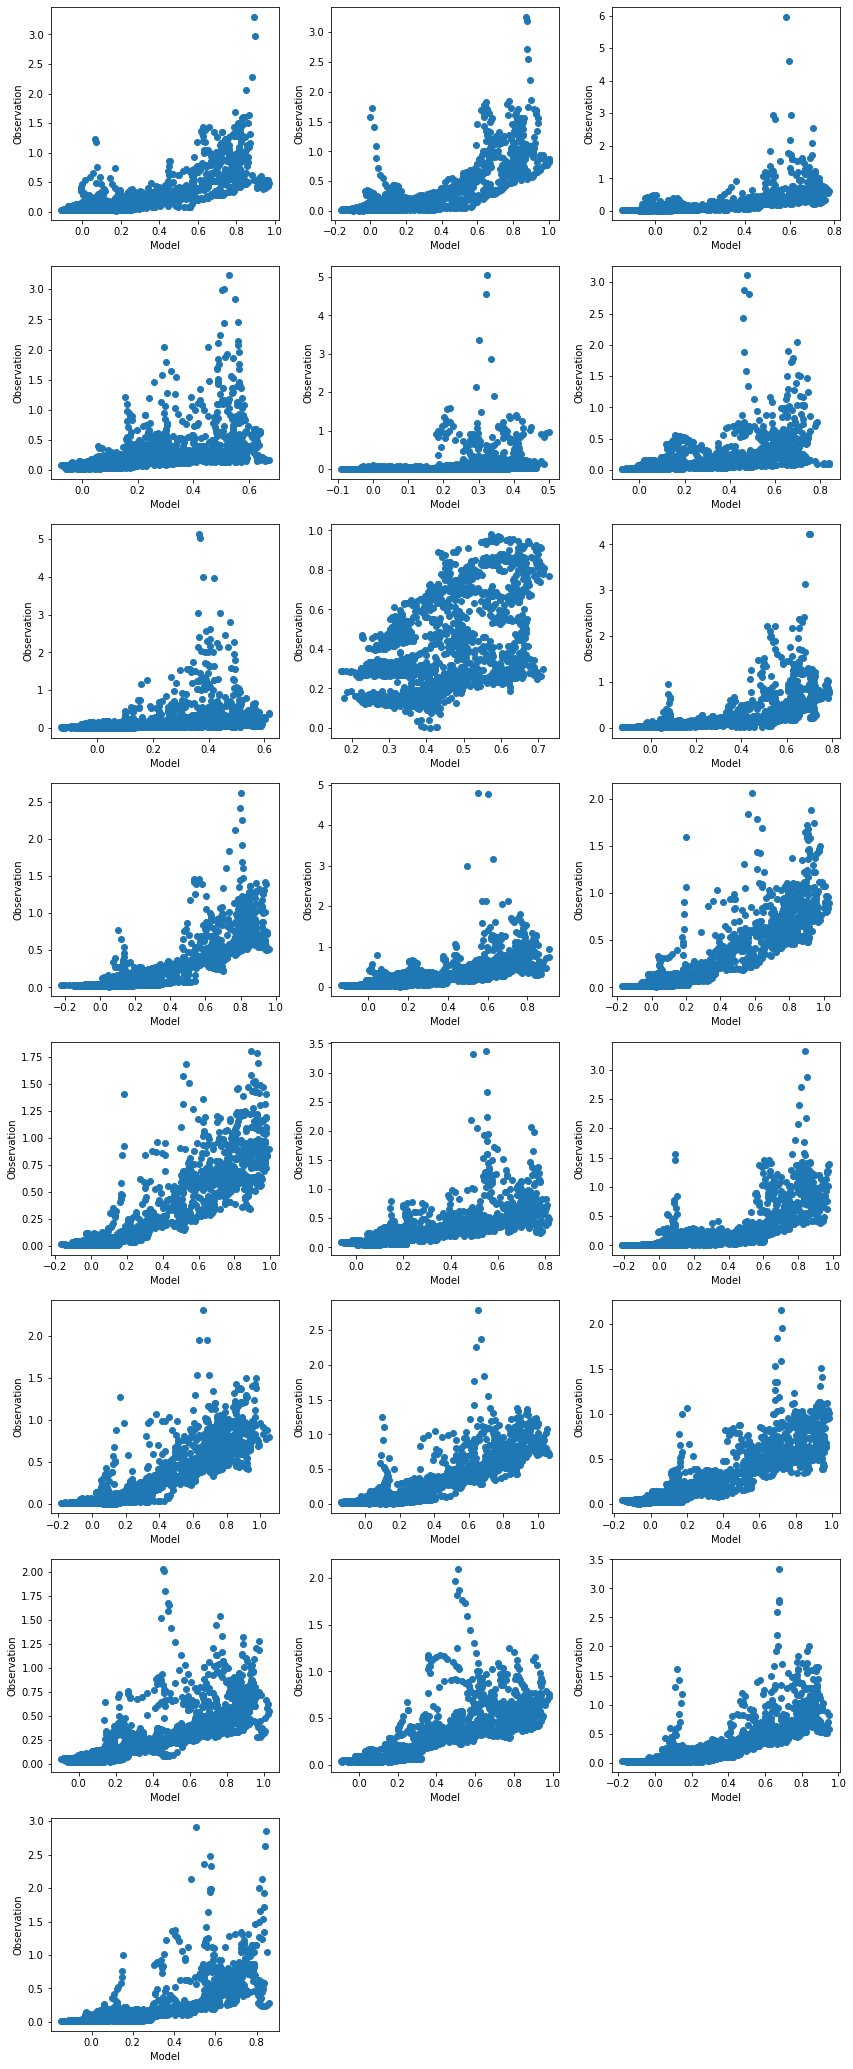

In [142]:
n_target = np.min((40, len(stationInds)))
plt.figure(figsize=(3*4,np.ceil(n_target/3)*4))

for pred in range(n_target):

    plt.subplot(int(np.ceil(n_target/3))+1,3,pred+1)
    xi = y_test_predicted[:,pred]
    #yi = y_transfer_test#[:,pred]
    yi = y_test[:,pred]
    plt.scatter(xi,yi)
    plt.xlabel('Model')
    plt.ylabel('Observation')
    #plt.ylim((-0.1,1))

plt.tight_layout()
plt.show()

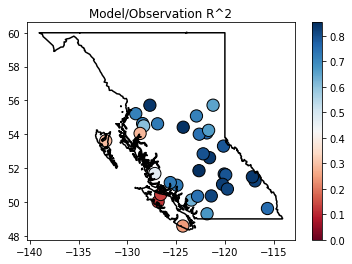

In [175]:
#check r2 at each station

from sklearn.metrics import r2_score

r2 = np.empty(np.shape(F)[1])
for kk in range(np.shape(F)[1]):
  r2[kk] = r2_score(y_test[:,kk],y_test_predicted[:,kk])

#visualize

#plt.scatter(stationLon[stationInds],stationLat[stationInds],c=r2,cmap='RdBu',vmin = 0, s = 150, edgecolors = 'k')
plt.scatter(stationLon[stationInds],stationLat[stationInds],c=r2,cmap='RdBu', s = 150, edgecolors = 'k', vmin = 0)
plot_prov(prov = prov)
plt.title('Model/Observation R^2')
plt.colorbar()
plt.show()

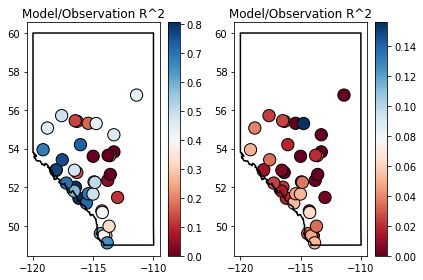

In [59]:
if predict_residuals:

  r2_res = np.empty(np.shape(F)[1])
  for kk in range(np.shape(F)[1]):
    r2_res[kk] = r2_score(y_test[:,kk],y_test_total_predicted[:,kk])

  #visualize

  plt.subplot(121)
  plt.scatter(stationLon[stationInds],stationLat[stationInds],c=r2_res,cmap='RdBu', s = 150, edgecolors = 'k', vmin = 0)
  plot_prov(prov = prov)
  plt.title('Model/Observation R^2')
  plt.colorbar()

  plt.subplot(122)
  plt.scatter(stationLon[stationInds],stationLat[stationInds],c=r2_res - r2,cmap='RdBu', s = 150, edgecolors = 'k', vmin = 0)
  plot_prov(prov = prov)
  plt.title('Model/Observation R^2')
  plt.colorbar()

  plt.tight_layout()

  plt.show()

In [0]:
dataPath = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/'

#what are the streamflow predictions at each station?

num_stations = len(stationInds)

NSE_station = []
NSE_station_test = []
NSE_rolling_station = []

for station in range(num_stations):
  
  NSE = nse(y[:,station], y_predicted[:,station])
  NSE_station.append(NSE)

  NSE_test = nse(y_test[:,station], y_test_predicted[:,station])
  NSE_station_test.append(NSE_test)

  NSE_rolling = nse_rolling(y[:,station], y_predicted[:,station], window = 366, stride = 365)
  NSE_rolling = np.asarray(NSE_rolling)
  thresh = 0
  indices = NSE_rolling < thresh
  NSE_rolling[indices] = 0
  NSE_rolling_station.append(NSE_rolling)

NSE_rolling_station = np.asarray(NSE_rolling_station).T
#NSE_rolling_station[np.argwhere(NSE_rolling_station<0)] = 0

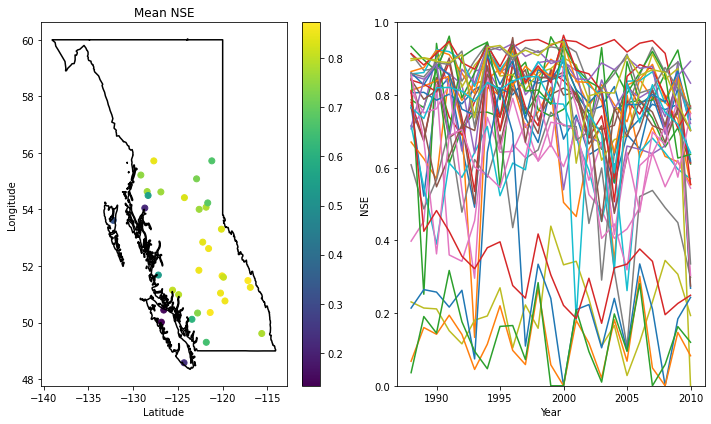

In [177]:
#visualize performance

saveIt = 0

plt.figure(figsize = (10,6))

plt.subplot(1,2,1)
#inds = stationsWithGlaciers[range(num_stations)]
#inds = [val for val in range(num_stations)]
plt.scatter(stationLon[stationInds], stationLat[stationInds], c = NSE_station)
plot_prov(prov = prov)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Mean NSE')
plt.colorbar()

plt.subplot(1,2,2)
plt.plot(range(1988,2011),NSE_rolling_station)
plt.xlabel('Year')
plt.ylabel('NSE')
plt.ylim((0,1))

plt.tight_layout()

if saveIt == 1:
  plt.savefig('meanNSE_and_series.png')

plt.show()

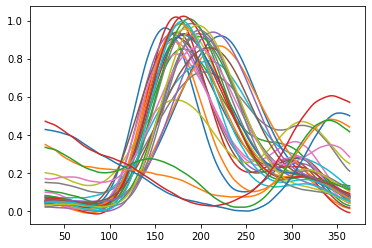

In [178]:
#compute smoothed seasonal over test period
#plan: find leap years, remove last day of SF from leap years, reshape SF at each station into matrix, find average

windowYears = flowDict['windowYears']
trainYears = windowYears[trainInds]
testYears = windowYears[testInds]
windowYears = windowYears[365:]
trainYears = trainYears[365:]

yearsForSOM = windowYears
yForSOM = np.copy(y_predicted)
totalYears = yearsForSOM[-1] - yearsForSOM[0]

##the first value in y_test is the second day in testInds
#y_new = np.empty((np.shape(y_test)[0],np.shape(y_test)[1]+1),dtype='single')
#y_new[:,1:] = y_test
#y_new[:,0] = y_new[:,1]

lastDayOfYear = np.argwhere(yearsForSOM[1:] - yearsForSOM[:-1] == 1) + 1
lastDayOfLeapYear = lastDayOfYear[np.argwhere(lastDayOfYear[1:]-lastDayOfYear[:-1] == 366)[:,0]+1]
lastDayOfLeapYear = np.vstack((lastDayOfLeapYear,366))
y_new1 = np.copy(yForSOM)
y_new2 = np.delete(y_new1,lastDayOfLeapYear,axis=0)

y_test_seasonal = np.empty((365,np.shape(F)[1]),dtype='single')
y_test_seasonal_smooth = np.empty_like(y_test_seasonal)

for streamGauge in range(num_stations):
    
    dummy = np.reshape(y_new2[:,streamGauge],(totalYears+1,365))
    y_test_seasonal[:,streamGauge] = np.mean(dummy,axis=0)
    
    x = pd.Series(y_test_seasonal[:,streamGauge])      
    y_test_seasonal_smooth[:,streamGauge] = x.rolling(30).mean()

for ii in range(np.shape(F)[1]):
    plt.plot(y_test_seasonal_smooth[:,ii])

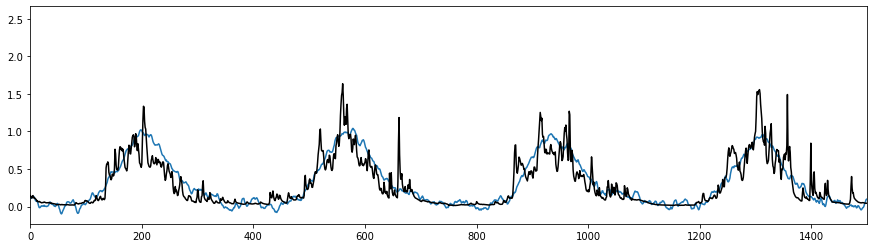

In [179]:
ind = 10

plt.figure(figsize = (15,4))
#plt.plot(y_predicted_bulk[:,0])
plt.plot(y_test_predicted[:,ind])
plt.plot(y_test[:,ind],'k')
#plt.ylim((-0.1,3))
plt.xlim((0,1500))
plt.show()

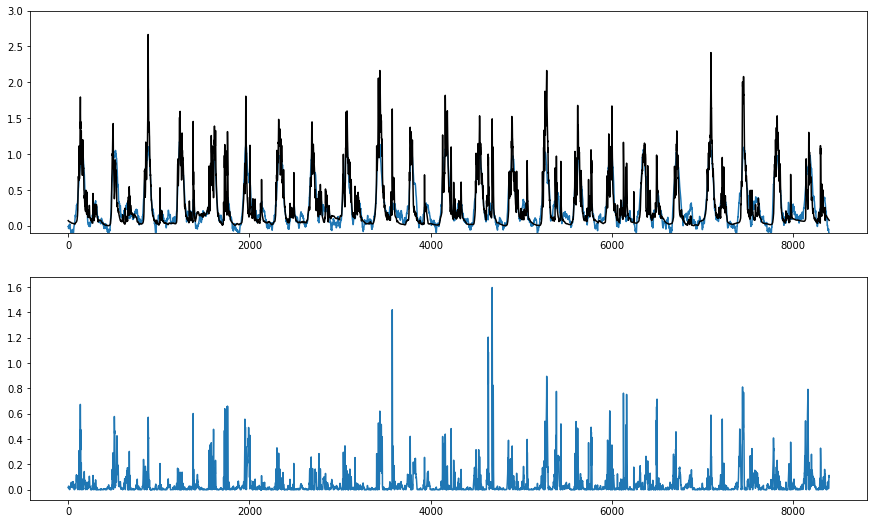

In [180]:
plt.figure(figsize = (15,9))

plt.subplot(2,1,1)
#plt.plot(y_predicted_bulk[:,0])
plt.plot(y_predicted[:,0])
plt.plot(y[:,0],'k')
plt.ylim((-0.1,3))
#plt.xlim((0,3000))

plt.subplot(2,1,2)
plt.plot((y_predicted[:,0] - y[:,0])**2 * np.abs(np.log(np.std(y, axis = 1))))
#plt.ylim((-0.1,3))
#plt.xlim((0,3000))
plt.show()

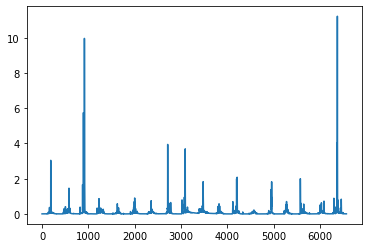

In [150]:
s = np.std(y_train,axis=1)
plt.plot(s**2)

/usr/local/lib/python3.6/dist-packages/minisom.py:304: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + c2*pc[pc_order[1]]


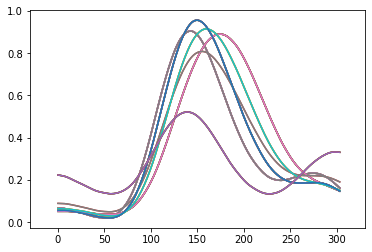

In [181]:
plt.plot(y_test_seasonal_smooth[0])

from minisom import MiniSom   
data = y_test_seasonal_smooth[31:-30].T
som = MiniSom(3, 2, 304, sigma=1, learning_rate=0.5) # initialization of 6x6 SOM
som.pca_weights_init(data)
som.train_random(data, 500) # trains the SOM with 100 iterations

qnt = som.quantization(data)

for ii in range(np.shape(F)[1]):
    plt.plot(qnt[ii,:])
    plt.xlim((-30,330))

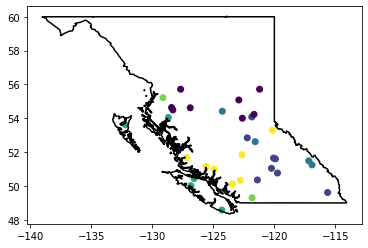

In [182]:
w = []
bmus = []
bmus_ref = [[1,4],[2,5],[3,6]]
for ii in range(np.shape(F)[1]):
    w.append(som.winner(data[ii,:]))
    bmus.append(bmus_ref[w[ii][0]][w[ii][1]])

plot_prov(prov=prov)
plt.scatter(stationLon[stationInds],stationLat[stationInds],c=bmus)

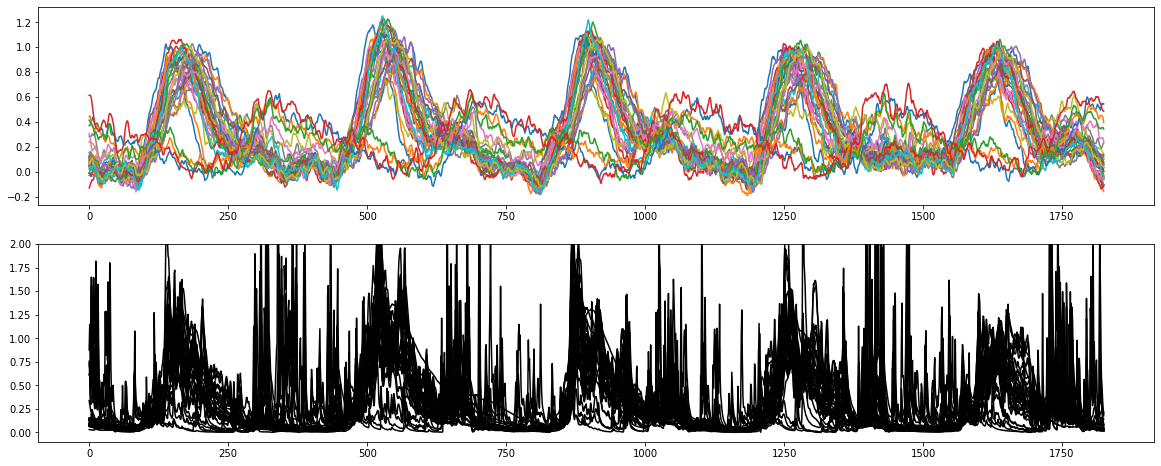

In [183]:
plt.figure(figsize = (20,8))
plt.subplot(211)
plt.plot(y_test_predicted)
#plt.ylim((-0.1,2))
#plt.ylim((-1,5))
plt.subplot(212)
plt.plot(y_test,'k')
plt.ylim((-0.1,2))
#plt.ylim((-1,5))
plt.show()

In [0]:
#cluster NSE time series

data = NSE_rolling_station.T

n_clusters = 3
kmeans = KMeans(n_clusters = n_clusters).fit(data)
labels = kmeans.labels_

#find mean pattern of each cluster
cluster_pattern = np.empty((n_clusters,np.shape(data)[1]))
for cluster_num in range(n_clusters):
    inds = np.argwhere(labels==cluster_num)
    cluster_pattern[cluster_num,:] = np.mean(data[inds,:],axis=0)
    
cluster_obs = np.empty((np.shape(data)))
for ind in range(len(data)):
    cluster_obs[ind] = cluster_pattern[labels[ind]]


AttributeError: ignored

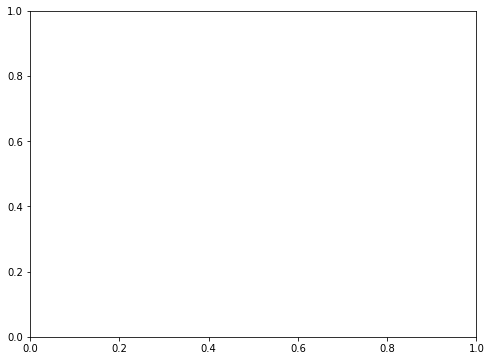

In [198]:
#visualize clusters

colours = 

plt.figure(figsize = (8,6))

plt.plot(cluster_pattern.T)
plt.xlabel('Year')
plt.title('Mean Pattern of Clusters')
plt.legend(['Cluster ' + str(ii) for ii in range(n_clusters)])
plt.ylim((0,1))
plt.show()

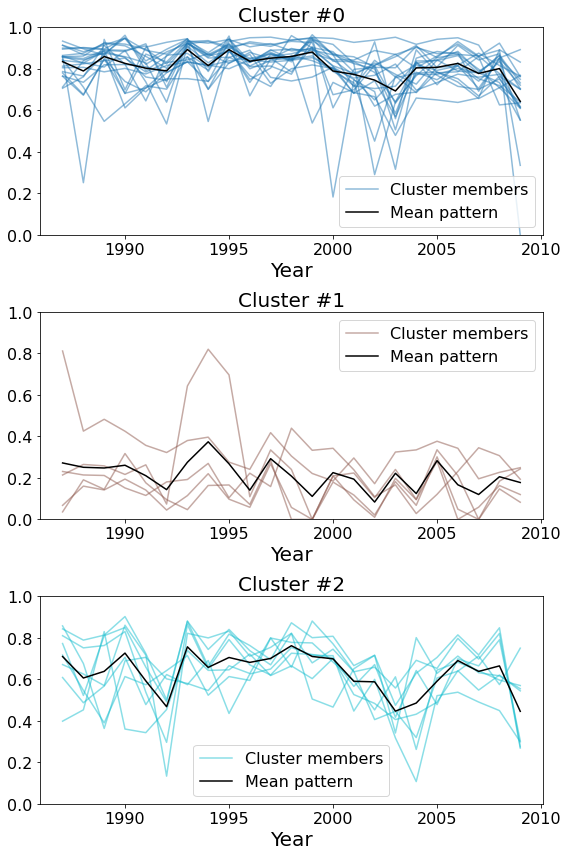

In [231]:
#visualize clusters

saveIt = 0

cmapname = 'tab10'
colours = cm.get_cmap(cmapname,n_clusters)

plt.figure(figsize = (8,n_clusters * 4))

for kk in range(n_clusters):
  
  inds = np.argwhere(labels == kk)

  plt.subplot(n_clusters,1,kk+1)

  plt.plot(np.arange(1987,2010),np.squeeze(data[inds[1:],:]).T, alpha = 0.5, color = colours(kk))
  plt.plot(np.arange(1987,2010),np.squeeze(data[inds[0],:]).T, alpha = 0.5, color = colours(kk), label = 'Cluster members')
  plt.plot(np.arange(1987,2010),cluster_pattern[kk,:], color = 'k', label = 'Mean pattern')
  plt.xlabel('Year', fontsize = 20)
  plt.title('Cluster #' + str(kk), fontsize = 20)
  plt.legend(fontsize = 16)
  plt.ylim((0,1))
  plt.tick_params(labelsize = 16)

plt.tight_layout()

if saveIt: 
  plt.savefig('NSE_clusters.png')

plt.show()

In [194]:
np.shape(inds)

(21, 1)

Median Test NSE = 0.73
Median All NSE = 0.77

Max Test NSE = 0.85
Max All NSE = 0.87

Min Test NSE = 0.12
Min All NSE = 0.13


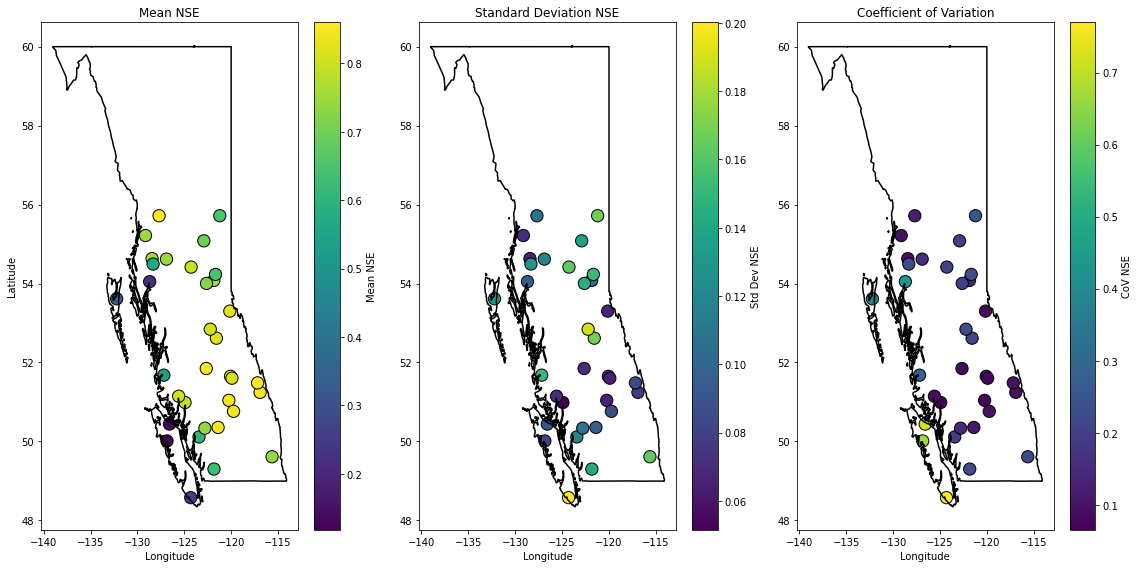

In [232]:
#plot mean NSE and variability of NSE

#inds = stationsWithGlaciers[range(num_stations)]

NSE_mean_stations = np.mean(NSE_rolling_station,axis=0)
NSE_mean_stations_test = np.mean(np.asarray(NSE_rolling_station)[-(testFinYear - testStartYear + 1):,:],axis=0)
NSE_std_stations = np.std(NSE_rolling_station,axis=0)
NSE_cov_stations = NSE_std_stations / NSE_mean_stations

print('Median Test NSE = ' + str(np.median(NSE_station_test))[:4])
print('Median All NSE = ' + str(np.median(NSE_station))[:4])
print('')
print('Max Test NSE = ' + str(np.max(NSE_station_test))[:4])
print('Max All NSE = ' + str(np.max(NSE_station))[:4])
print('')
print('Min Test NSE = ' + str(np.min(NSE_station_test))[:4])
print('Min All NSE = ' + str(np.min(NSE_station))[:4])

plt.figure(figsize = (16,8))

plt.subplot(1,3,1)
plt.scatter(stationLon[stationInds], stationLat[stationInds], c = NSE_mean_stations, s = 150, edgecolors = 'k')
plot_prov(prov = prov)
#plt.scatter(stationLon[inds[-4:]],stationLat[inds[-4:]], marker = 's')
cbar = plt.colorbar()
cbar.set_label('Mean NSE')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Mean NSE')

plt.subplot(1,3,2)
plt.scatter(stationLon[stationInds], stationLat[stationInds], c = NSE_std_stations, s = 150, edgecolors = 'k')
plot_prov(prov = prov)
cbar = plt.colorbar()
cbar.set_label('Std Dev NSE')
plt.xlabel('Longitude')
plt.title('Standard Deviation NSE')

plt.subplot(1,3,3)
plt.scatter(stationLon[stationInds], stationLat[stationInds], c = NSE_cov_stations, s = 150, edgecolors = 'k')
plot_prov(prov = prov)
cbar = plt.colorbar()
cbar.set_label('CoV NSE')
plt.xlabel('Longitude')
plt.title('Coefficient of Variation')

plt.tight_layout()
plt.show()

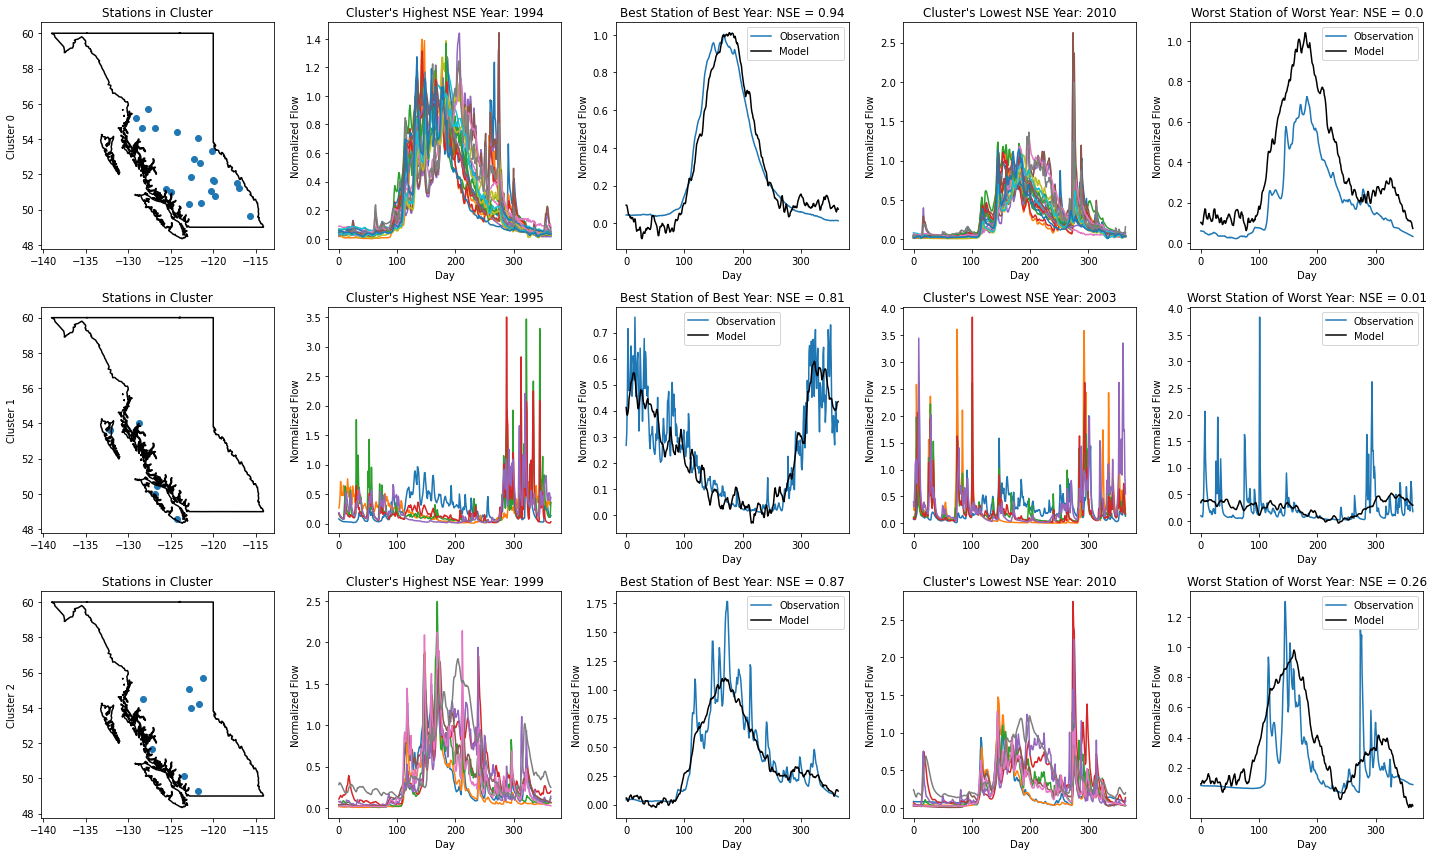

In [233]:
#what are the characteristics of the years with the highest and lowest NSE?

#make plot: rows are clusters, columns are 'best performing years' and 'worst performing years'

years = range(1988,2011)
n_cols = 5
plt.figure(figsize = (n_cols*4, n_clusters*4))

for cluster in range(n_clusters): #for each cluster

  #identify indices of rivers in this cluster
  stations_in_cluster = np.squeeze(stationInds[np.argwhere(labels==cluster)])
  if np.size(stations_in_cluster)==1: #if only one station, expand dimensions so array has a length of 1 so we can index the array
    stations_in_cluster = np.expand_dims(stations_in_cluster, axis = 0)
  stations_in_cluster_inds = np.reshape([np.argwhere(stationInds == stations_in_cluster[kk]) for kk in range(len(stations_in_cluster))],(-1,))

  #identify best and worst years/stations
  best_year = np.argmax(cluster_pattern[cluster])
  worst_year = np.argmin(cluster_pattern[cluster])
  NSE_stations_in_cluster = NSE_rolling_station[:,stations_in_cluster_inds]
  NSE_stations_best_year = NSE_stations_in_cluster[best_year,:]
  NSE_stations_worst_year = NSE_stations_in_cluster[worst_year,:]
  best_station_ind = stations_in_cluster_inds[np.argmax(NSE_stations_best_year)]
  worst_station_ind = stations_in_cluster_inds[np.argmin(NSE_stations_worst_year)]

  #plot stations in this cluster
  plt.subplot(n_clusters, n_cols, cluster*n_cols + 1)
  plot_prov(prov = prov)
  plt.scatter(stationLon[stations_in_cluster], stationLat[stations_in_cluster])
  plt.ylabel('Cluster ' + str(cluster))
  plt.title('Stations in Cluster')

  #plot all cluster members' flow during this best year
  plt.subplot(n_clusters, n_cols, cluster*n_cols + 2)
  for kk in stations_in_cluster_inds: #for each stream gauge in cluster
    start_ind = best_year*365
    final_ind = start_ind + 365
    plt.plot(y[start_ind:final_ind,kk])
    plt.xlabel('Day')
    plt.ylabel('Normalized Flow')
    plt.title('Cluster\'s Highest NSE Year: ' + str(years[best_year]))

  #plot the best performing cluster member in this best year, and it's modelled output
  plt.subplot(n_clusters, n_cols, cluster*n_cols + 3)
  start_ind = best_year*365
  final_ind = start_ind + 365
  plt.plot(y[start_ind:final_ind,best_station_ind], label = 'Observation')
  plt.plot(y_predicted[start_ind:final_ind,best_station_ind], color = 'k', label = 'Model')
  plt.xlabel('Day')
  plt.ylabel('Normalized Flow')
  plt.title('Best Station of Best Year: NSE = ' + str(NSE_rolling_station[best_year, best_station_ind])[:4])
  plt.legend()

  #plot all cluster members' flow during this worst year
  plt.subplot(n_clusters, n_cols, cluster*n_cols + 4)
  for kk in stations_in_cluster_inds: #for each stream gauge in cluster
    start_ind = worst_year*365
    final_ind = start_ind + 365
    plt.plot(y[start_ind:final_ind,kk])
    plt.xlabel('Day')
    plt.ylabel('Normalized Flow')
    plt.title('Cluster\'s Lowest NSE Year: ' + str(years[worst_year]))

  #plot the worst performing cluster member in this worst year, and it's modelled output
  plt.subplot(n_clusters, n_cols, cluster*n_cols + 5)
  start_ind = worst_year*365
  final_ind = start_ind + 365
  plt.plot(y[start_ind:final_ind,worst_station_ind], label = 'Observation')
  plt.plot(y_predicted[start_ind:final_ind, worst_station_ind], color = 'k', label = 'Model')
  plt.xlabel('Day')
  plt.ylabel('Normalized Flow')
  plt.title('Worst Station of Worst Year: NSE = ' + str(NSE_rolling_station[worst_year, worst_station_ind])[:4])
  plt.legend()

  plt.tight_layout()

plt.show()



# What is the model learning?

In [0]:
del x_train, history, x

In [0]:
del Tmax, Tmin, P, H, S, x_lat, x_lon

In [0]:
del Tmaxnorm, Tminnorm, Pnorm, Hnorm, Snorm, x_lat_norm, x_lon_norm

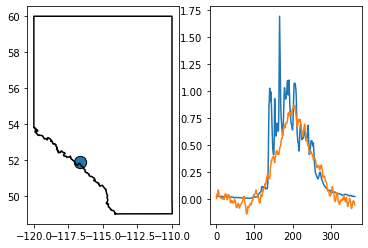

In [91]:
station = 11
plt.subplot(121)
plot_prov(prov = prov)
plt.scatter(stationLon[stationInds[station]], stationLat[stationInds[station]], s = 150, edgecolor = 'k')

plt.subplot(122)
plt.plot(y_test[:365,station])
plt.plot(y_test_predicted[:365,station])

plt.show()

In [186]:
#generate heat maps

iters_total = 100
iters_one_pass = 100
days = range(180,200) #number of days to perturb
#day = 160 #day we're looking into
station = station #station we're looking into
p_1 = 0.9 #probability of 1 in mask
perturb_single_channel = False #if true, only perturb one of the channels to see what it's looking at
channel_perturb = 2 #if perturb_single_channel is True, this is the channel to be perturbing

h = 4
w = 4
H = np.shape(x_test)[2]
W = np.shape(x_test)[3]

heat_all_slices = []
heat_days = []
jj = 0

start = time.process_time()

for day in days:

  print('Day ' + str(day) + '/' + str(days[-1]))

  for kk in range(int(iters_total/iters_one_pass)):

    print('   Iteration: ' + str(kk*iters_one_pass) + '/' + str(iters_total))

    now = time.process_time() - start

    iters = iters_one_pass

    x_int = np.arange(0,W+np.round(W/w) - 0.1,np.round(W/w))
    y_int = np.arange(0,H+np.round(H/h) - 0.1,np.round(H/h))
    xnew = np.arange(0,W,1)
    ynew = np.arange(0,H,1)

    now = time.process_time() - start
    #print('2: ' + str(now)[:6])

    mask_small = np.random.choice([0,1],size = (iters,1,h+1,w+1), p = [1-p_1,p_1])
    mask_large = np.half([interpolate.interp2d(x_int,y_int,mask_small[iter][0])(xnew,ynew) for iter in range(iters)])
    mask_large_2D = np.copy(mask_large)
    mask_large = np.repeat(np.expand_dims(np.asarray(mask_large),3),nchannels, axis = 3)
    mask_large = np.repeat(np.expand_dims(np.asarray(mask_large),1),365, axis = 1)

    now = time.process_time() - start
    #print('3: ' + str(now)[:6])

    if perturb_single_channel is True:
      for channel in range(nchannels):
        if channel != channel_perturb:
          mask_large[:,:,:,:,channel] = 1

    now = time.process_time() - start
    #print('4: ' + str(now)[:6])

    day_slice = [day]
    xday = x_test[day]

    now = time.process_time() - start
    #print('5a: ' + str(now)[:6])

    #xday_iters = [np.repeat(xday,iters,axis=0) for day in range(len(day_slice))] #dimension: [days, iterations*365, lat, lon, channels]
    ###xday_iters = [np.repeat(xday,iters,axis=0)]
    #print(np.shape(xday_iters))
    ###xday_iters = np.reshape(xday_iters, (iters, 365, ) + np.shape(T[0]) + (nchannels,)) #dimension: [days*iterations*365, lat, lon, channels]; for passing through model
    #print(np.shape(xday_iters))
    
    xday_iters = np.asarray([xday for val in range(iters)])

    now = time.process_time() - start
    #print('5b: ' + str(now)[:6])

    #xday_iters_mask = [xday_iters[jj:jj+iters] * mask_large for jj in np.arange(0,len(day_slice)*iters,iters)]
    if perturb_single_channel is True:
      xday_iters_mask = xday_iters
      xday_iters_mask[:,:,:,:,channel_perturb] = np.multiply(xday_iters[:,:,:,:,channel_perturb],mask_large[:,:,:,:,channel_perturb])
    else: 
      xday_iters_mask = np.multiply(xday_iters,mask_large)
    #print(np.shape(xday_iters_mask))

    now = time.process_time() - start
    #print('5c: ' + str(now)[:6])

    #xday_iters_mask = np.reshape(xday_iters_mask,(iters, 365) + np.shape(T[0]) + (nchannels,))
    #xday_iters_mask = np.squeeze(xday_iters_mask)
    #print(np.shape(xday_iters_mask))

    now = time.process_time() - start
    #print('5: ' + str(now)[:6])

    x_all = np.squeeze(np.concatenate((np.expand_dims(xday, axis = 0),xday_iters_mask)))
    #print(np.shape(x_all))
    y_all = model.predict(x_all, batch_size = 128)

    now = time.process_time() - start
    #print('6: ' + str(now)[:6])

    yday = y_all[:len(day_slice)]
    yday_mask = y_all[len(day_slice):]

    yday_station = yday[:,station]
    yday_station_mask = yday_mask[:,station]

    ydiffs = np.abs(np.reshape([yday_station[jj] - yday_station_mask[jj*iters:jj*iters + iters] for jj in range(len(day_slice))],(-1,1)))
    delta = np.ones((len(ydiffs),H,W)) * ydiffs[:,None]
    heat_iters = [np.asarray(delta[jj*iters:(jj+1)*iters]) * (1 - np.asarray(mask_large_2D)) for jj in range(len(day_slice))]
    heat_iters = np.reshape(heat_iters,(len(day_slice)*iters,H,W))
    heat = [np.mean(heat_iters[jj*iters : (jj+1)*iters], axis=0) for jj in range(len(day_slice))] #fast
    #heat = [np.transpose(heat[kk]) for kk in range(len(day_slice))] #fast
    heat_all_slices.append(heat[0]) #fast
    #print(np.shape(heat_iters))

    del heat, heat_iters, delta, ydiffs, x_all, xday_iters

  heat_days.append(np.mean(heat_all_slices[jj : jj + int(iters_total/iters_one_pass)], axis = 0))
  jj += int(iters_total/iters_one_pass)

heat_mean = np.mean(heat_all_slices,axis=0)
heat_max = [np.max(heat_days[kk]) for kk in range(len(days))]

now = time.process_time() - start
print(    str(now)[:6])

Day 180/199
   Iteration: 0/100
Day 181/199
   Iteration: 0/100
Day 182/199
   Iteration: 0/100
Day 183/199
   Iteration: 0/100
Day 184/199
   Iteration: 0/100


KeyboardInterrupt: ignored

In [0]:
#visualize: where is the model most sensitive on average?

plt.figure(figsize = (6,8))
plot_prov(prov = prov)
plt.imshow(heat_mean,aspect='auto', cmap = 'RdBu_r',extent = extentERA)
plt.colorbar()
plt.scatter(stationLon[stationInds[station]],stationLat[stationInds[station]], facecolor = 'w', edgecolor = 'k', s = 75, zOrder = 5)
plt.title('Model Sensitivity',fontsize = 20)

plt.show()

In [248]:
#RESIDUAL

iters_total = 100
iters_one_pass = 100
year = 1
days = range(160,200) #number of days to perturb
#station = station #station we're looking into
p_1 = 0.9 #probability of 1 in mask
perturb_single_channel = False #if true, only perturb one of the channels to see what it's looking at
channel_perturb = 0 #if perturb_single_channel is True, this is the channel to be perturbing

h = 5
w = 5
H = np.shape(x_test)[2]
W = np.shape(x_test)[3]

heat_all_slices = [[] for station in range(np.shape(y_test)[0])]
heat_days = [[] for station in range(np.shape(y_test)[0])]
jj = 0

start = time.process_time()

for day in days:

  print('Day ' + str(day) + '/' + str(days[-1]))

  for kk in range(int(iters_total/iters_one_pass)):

    print('   Iteration: ' + str(kk*iters_one_pass) + '/' + str(iters_total))

    now = time.process_time() - start
    #print('1: ' + str(now)[:6])

    iters = iters_one_pass

    x_int = np.arange(0,W+np.round(W/w) - 0.1,np.round(W/w))
    y_int = np.arange(0,H+np.round(H/h) - 0.1,np.round(H/h))
    xnew = np.arange(0,W,1)
    ynew = np.arange(0,H,1)

    now = time.process_time() - start
    #print('2: ' + str(now)[:6])

    mask_small = np.random.choice([0,1],size = (iters,1,h+1,w+1), p = [1-p_1,p_1])
    mask_large = np.half([interpolate.interp2d(x_int,y_int,mask_small[iter][0])(xnew,ynew) for iter in range(iters)])
    mask_large_2D = np.copy(mask_large)
    mask_large = np.repeat(np.expand_dims(np.asarray(mask_large),3),nchannels, axis = 3)
    mask_large = np.repeat(np.expand_dims(np.asarray(mask_large),1),365, axis = 1)

    now = time.process_time() - start
    #print('3: ' + str(now)[:6])

    if perturb_single_channel is True:
      for channel in range(nchannels):
        if channel != channel_perturb:
          mask_large[:,:,:,:,channel] = 1

    now = time.process_time() - start
    #print('4: ' + str(now)[:6])

    day_slice = [day]
    xday = x_test[day]

    now = time.process_time() - start
    #print('5a: ' + str(now)[:6])

    #xday_iters = [np.repeat(xday,iters,axis=0) for day in range(len(day_slice))] #dimension: [days, iterations*365, lat, lon, channels]
    ###xday_iters = [np.repeat(xday,iters,axis=0)]
    #print(np.shape(xday_iters))
    ###xday_iters = np.reshape(xday_iters, (iters, 365, ) + np.shape(T[0]) + (nchannels,)) #dimension: [days*iterations*365, lat, lon, channels]; for passing through model
    #print(np.shape(xday_iters))
    
    xday_iters = np.asarray([xday for val in range(iters)])

    now = time.process_time() - start
    #print('5b: ' + str(now)[:6])

    #xday_iters_mask = [xday_iters[jj:jj+iters] * mask_large for jj in np.arange(0,len(day_slice)*iters,iters)]
    if perturb_single_channel is True:
      xday_iters_mask = xday_iters
      xday_iters_mask[:,:,:,:,channel_perturb] = np.multiply(xday_iters[:,:,:,:,channel_perturb],mask_large[:,:,:,:,channel_perturb])
    else: 
      xday_iters_mask = np.multiply(xday_iters,mask_large)
    #print(np.shape(xday_iters_mask))

    now = time.process_time() - start
    #print('5c: ' + str(now)[:6])

    #xday_iters_mask = np.reshape(xday_iters_mask,(iters, 365) + np.shape(T[0]) + (nchannels,))
    #xday_iters_mask = np.squeeze(xday_iters_mask)
    #print(np.shape(xday_iters_mask))

    now = time.process_time() - start
    #print('5: ' + str(now)[:6])

    x_all = np.squeeze(np.concatenate((np.expand_dims(xday, axis = 0),xday_iters_mask)))
    #print(np.shape(x_all))
    y_all = model_res.predict(x_all, batch_size = 128)

    now = time.process_time() - start
    #print('6: ' + str(now)[:6])

    yday = y_all[:len(day_slice)]
    yday_mask = y_all[len(day_slice):]

    for station in range(np.shape(y_all)[1]):
      yday_station = yday[:,station]
      yday_station_mask = yday_mask[:,station]

      ydiffs = np.abs(np.reshape([yday_station[jj] - yday_station_mask[jj*iters:jj*iters + iters] for jj in range(len(day_slice))],(-1,1)))
      delta = np.ones((len(ydiffs),H,W)) * ydiffs[:,None]
      heat_iters = [np.asarray(delta[jj*iters:(jj+1)*iters]) * (1 - np.asarray(mask_large_2D)) for jj in range(len(day_slice))]
      heat_iters = np.reshape(heat_iters,(len(day_slice)*iters,H,W))
      heat = [np.mean(heat_iters[jj*iters : (jj+1)*iters], axis=0) for jj in range(len(day_slice))] #fast
      
      heat_all_slices[station].append(heat[0]) #fast
      #print(np.shape(heat_iters))

    del heat, heat_iters, delta, ydiffs, x_all, xday_iters

  for station in range(np.shape(y_all)[1]):
    heat_days[station].append(np.mean(heat_all_slices[station][jj : jj + int(iters_total/iters_one_pass)], axis = 0))
  jj += int(iters_total/iters_one_pass)

heat_mean = np.empty( (np.shape(y_all)[1] ,) + np.shape(np.mean(heat_all_slices[0],axis=0)) )
heat_max = np.empty( (np.shape(y_all)[1] ,) + np.shape([np.max(heat_days[0][kk]) for kk in range(len(days))]))
for station in range(np.shape(y_all)[1]):
  heat_mean[station] = np.mean(heat_all_slices[station],axis=0)
  heat_max[station] = [np.max(heat_days[station][kk]) for kk in range(len(days))]

now = time.process_time() - start
print(    str(now)[:6])

Day 160/199
   Iteration: 0/100
Day 161/199
   Iteration: 0/100
Day 162/199
   Iteration: 0/100
Day 163/199
   Iteration: 0/100
Day 164/199
   Iteration: 0/100
Day 165/199
   Iteration: 0/100
Day 166/199
   Iteration: 0/100
Day 167/199
   Iteration: 0/100
Day 168/199
   Iteration: 0/100
Day 169/199
   Iteration: 0/100
Day 170/199
   Iteration: 0/100
Day 171/199
   Iteration: 0/100
Day 172/199
   Iteration: 0/100
Day 173/199
   Iteration: 0/100
Day 174/199
   Iteration: 0/100
Day 175/199
   Iteration: 0/100
Day 176/199
   Iteration: 0/100
Day 177/199
   Iteration: 0/100
Day 178/199
   Iteration: 0/100
Day 179/199
   Iteration: 0/100
Day 180/199
   Iteration: 0/100
Day 181/199
   Iteration: 0/100
Day 182/199
   Iteration: 0/100
Day 183/199
   Iteration: 0/100
Day 184/199
   Iteration: 0/100
Day 185/199
   Iteration: 0/100
Day 186/199
   Iteration: 0/100
Day 187/199
   Iteration: 0/100
Day 188/199
   Iteration: 0/100
Day 189/199
   Iteration: 0/100
Day 190/199
   Iteration: 0/100
Day 191/

In [296]:
#EDIT THIS ONE -- GOAL: generate heat maps at all stations, all at once

iters_total = 100
iters_one_pass = 100
year = 1
days = range(160,200) #number of days to perturb
#station = station #station we're looking into
p_1 = 0.9 #probability of 1 in mask
perturb_single_channel = False #if true, only perturb one of the channels to see what it's looking at
channel_perturb = -1 #if perturb_single_channel is True, this is the channel to be perturbing

h = 5
w = 5
H = np.shape(x_test)[2]
W = np.shape(x_test)[3]

heat_all_slices = [[] for station in range(np.shape(y_test)[0])]
heat_days = [[] for station in range(np.shape(y_test)[0])]
jj = 0

start = time.process_time()

for day in days:

  print('Day ' + str(day) + '/' + str(days[-1]))

  for kk in range(int(iters_total/iters_one_pass)):

    print('   Iteration: ' + str(kk*iters_one_pass) + '/' + str(iters_total))

    now = time.process_time() - start
    #print('1: ' + str(now)[:6])

    iters = iters_one_pass

    #x_int = np.arange(0,W+np.round(W/w) - 0.1,np.round(W/w))
    #y_int = np.arange(0,H+np.round(H/h) - 0.1,np.round(H/h))

    x_int = np.linspace(0,W,w)
    y_int = np.linspace(0,H,h)

    xnew = np.arange(0,W,1)
    ynew = np.arange(0,H,1)

    now = time.process_time() - start
    #print('2: ' + str(now)[:6])

    mask_small = np.random.choice([0,1],size = (iters,1,h,w), p = [1-p_1,p_1])
    mask_large = np.half([interpolate.interp2d(x_int,y_int,mask_small[iter][0])(xnew,ynew) for iter in range(iters)])
    mask_large_2D = np.copy(mask_large)
    mask_large = np.repeat(np.expand_dims(np.asarray(mask_large),3),nchannels, axis = 3)
    mask_large = np.repeat(np.expand_dims(np.asarray(mask_large),1),365, axis = 1)

    now = time.process_time() - start
    #print('3: ' + str(now)[:6])

    if perturb_single_channel is True:
      for channel in range(nchannels):
        if channel != channel_perturb:
          mask_large[:,:,:,:,channel] = 1

    now = time.process_time() - start
    #print('4: ' + str(now)[:6])

    day_slice = [day]
    xday = x_test[day]

    now = time.process_time() - start
    #print('5a: ' + str(now)[:6])

    #xday_iters = [np.repeat(xday,iters,axis=0) for day in range(len(day_slice))] #dimension: [days, iterations*365, lat, lon, channels]
    ###xday_iters = [np.repeat(xday,iters,axis=0)]
    #print(np.shape(xday_iters))
    ###xday_iters = np.reshape(xday_iters, (iters, 365, ) + np.shape(T[0]) + (nchannels,)) #dimension: [days*iterations*365, lat, lon, channels]; for passing through model
    #print(np.shape(xday_iters))
    
    xday_iters = np.asarray([xday for val in range(iters)])

    now = time.process_time() - start
    #print('5b: ' + str(now)[:6])

    #xday_iters_mask = [xday_iters[jj:jj+iters] * mask_large for jj in np.arange(0,len(day_slice)*iters,iters)]
    if perturb_single_channel is True:
      xday_iters_mask = xday_iters
      xday_iters_mask[:,:,:,:,channel_perturb] = np.multiply(xday_iters[:,:,:,:,channel_perturb],mask_large[:,:,:,:,channel_perturb])
    else: 
      #xday_iters_mask = np.multiply(xday_iters,mask_large)
      factor = np.random.choice([-1,1],p = [0.5,0.5])
      xday_iters_mask = np.add(xday_iters,factor*(1-mask_large))
    #print(np.shape(xday_iters_mask))

    now = time.process_time() - start
    #print('5c: ' + str(now)[:6])

    #xday_iters_mask = np.reshape(xday_iters_mask,(iters, 365) + np.shape(T[0]) + (nchannels,))
    #xday_iters_mask = np.squeeze(xday_iters_mask)
    #print(np.shape(xday_iters_mask))

    now = time.process_time() - start
    #print('5: ' + str(now)[:6])

    x_all = np.squeeze(np.concatenate((np.expand_dims(xday, axis = 0),xday_iters_mask)))
    #print(np.shape(x_all))
    y_all = model.predict(x_all, batch_size = 128)

    now = time.process_time() - start
    #print('6: ' + str(now)[:6])

    yday = y_all[:len(day_slice)]
    yday_mask = y_all[len(day_slice):]

    for station in range(np.shape(y_all)[1]):
      yday_station = yday[:,station]
      yday_station_mask = yday_mask[:,station]

      ydiffs = np.abs(np.reshape([yday_station[jj] - yday_station_mask[jj*iters:jj*iters + iters] for jj in range(len(day_slice))],(-1,1)))
      delta = np.ones((len(ydiffs),H,W)) * ydiffs[:,None]
      heat_iters = [np.asarray(delta[jj*iters:(jj+1)*iters]) * (1 - np.asarray(mask_large_2D)) for jj in range(len(day_slice))]
      heat_iters = np.reshape(heat_iters,(len(day_slice)*iters,H,W))
      heat = [np.mean(heat_iters[jj*iters : (jj+1)*iters], axis=0) for jj in range(len(day_slice))] #fast
      
      heat_all_slices[station].append(heat[0]) #fast
      #print(np.shape(heat_iters))

    del heat, heat_iters, delta, ydiffs, x_all, xday_iters

  for station in range(np.shape(y_all)[1]):
    heat_days[station].append(np.mean(heat_all_slices[station][jj : jj + int(iters_total/iters_one_pass)], axis = 0))
  jj += int(iters_total/iters_one_pass)

heat_mean = np.empty( (np.shape(y_all)[1] ,) + np.shape(np.mean(heat_all_slices[0],axis=0)) )
heat_max = np.empty( (np.shape(y_all)[1] ,) + np.shape([np.max(heat_days[0][kk]) for kk in range(len(days))]))
for station in range(np.shape(y_all)[1]):
  heat_mean[station] = np.mean(heat_all_slices[station],axis=0)
  heat_max[station] = [np.max(heat_days[station][kk]) for kk in range(len(days))]

now = time.process_time() - start
print(    str(now)[:6])

Day 160/199
   Iteration: 0/100
Day 161/199
   Iteration: 0/100
Day 162/199
   Iteration: 0/100
Day 163/199
   Iteration: 0/100
Day 164/199
   Iteration: 0/100
Day 165/199
   Iteration: 0/100
Day 166/199
   Iteration: 0/100
Day 167/199
   Iteration: 0/100
Day 168/199
   Iteration: 0/100
Day 169/199
   Iteration: 0/100
Day 170/199
   Iteration: 0/100
Day 171/199
   Iteration: 0/100
Day 172/199
   Iteration: 0/100
Day 173/199
   Iteration: 0/100
Day 174/199
   Iteration: 0/100
Day 175/199
   Iteration: 0/100
Day 176/199
   Iteration: 0/100
Day 177/199
   Iteration: 0/100
Day 178/199
   Iteration: 0/100
Day 179/199
   Iteration: 0/100
Day 180/199
   Iteration: 0/100
Day 181/199
   Iteration: 0/100
Day 182/199
   Iteration: 0/100
Day 183/199
   Iteration: 0/100
Day 184/199
   Iteration: 0/100
Day 185/199
   Iteration: 0/100
Day 186/199
   Iteration: 0/100
Day 187/199
   Iteration: 0/100
Day 188/199
   Iteration: 0/100
Day 189/199
   Iteration: 0/100
Day 190/199
   Iteration: 0/100
Day 191/

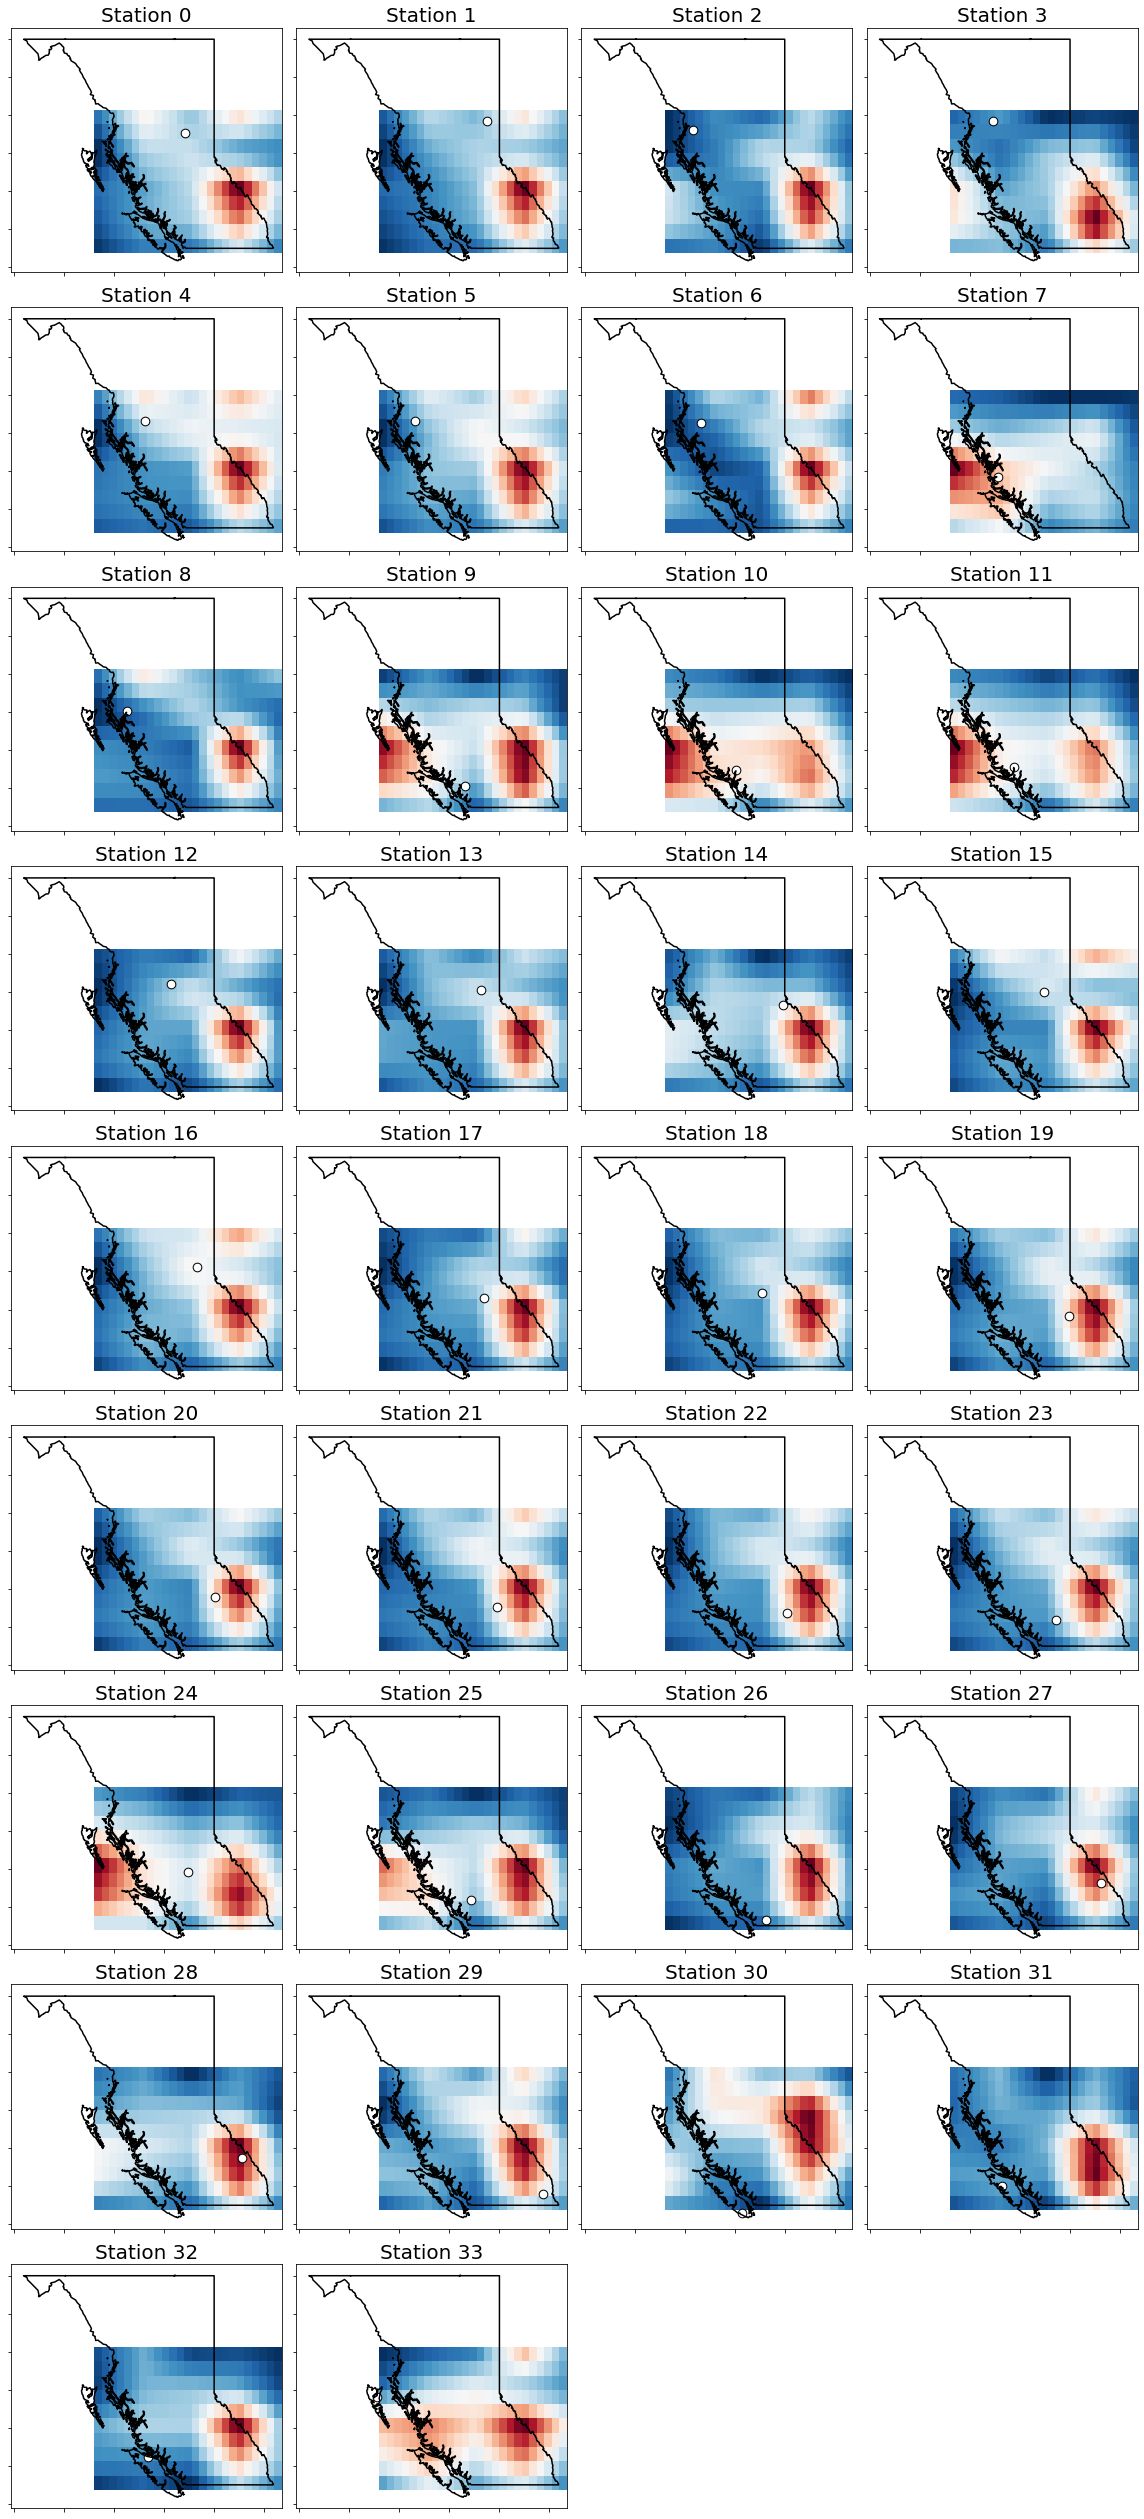

In [297]:
#visualize: where is the model sensitive when predicting each station?

saveIt = 0

plt.figure(figsize = (4*4,len(stationInds)*4))

#vmin = np.min(heat_days)
#vmax = np.max(heat_days)

for kk in range(len(stationInds)):
  plt.subplot(len(stationInds)+1,4,kk+1)
  plt.imshow(heat_mean[kk], aspect = 'auto', cmap = 'RdBu_r', extent = extentERA)#, vmin = vmin, vmax = vmax)
  plot_prov(prov = prov)
  plt.scatter(stationLon[stationInds[kk]],stationLat[stationInds[kk]], facecolor = 'w', edgecolor = 'k', s = 75)
  plt.title('Station ' + str(kk), fontsize = 20)
  plt.tick_params(labelbottom = False, labelleft = False)

plt.tight_layout()

if saveIt:
  plt.savefig('model_focus_average.png')

In [0]:
#characterize heat maps in terms of their 'peakiness' and the distance from max heat to station

d = np.empty((len(stationInds)))
A = np.empty((len(stationInds)))

for station in range(len(stationInds)): #for each station, find distance 'd' to max heat

  indLon = np.argmax(heat_mean[station], axis = 0)
  indLat = np.argmax(heat_mean[station], axis = 1)

  inds = np.where(heat_mean[station] == np.max(heat_mean[station]))
  indLat = inds[0]
  indLon = inds[1]

  d[station] = np.sqrt( (eraLat[indLat] - stationLat[stationInds[station]])**2 + (eraLon[indLon] - stationLon[stationInds[station]])**2 )

  halfMax = 0.5* (np.max(heat_mean[station]) - np.min(heat_mean[station]))
  A[station] = len(np.argwhere((heat_mean[station] - np.min(heat_mean[station])) > halfMax))

Text(0, 0.5, 'A')

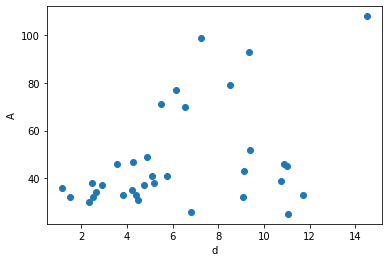

In [299]:
plt.scatter(d,A)
plt.xlabel('d')
plt.ylabel('A')

In [0]:
#cluster: what are the most characteristic heat maps?

data = np.asarray([np.squeeze(np.reshape(heat_station, (1,-1))) for heat_station in heat_mean])
data_mean = data.mean(axis=1)
data_std = data.std(axis=1)
#data_norm = [(data[kk] - data_mean[kk]) / data_std[kk] for kk in range(len(data))]
data_norm = [data[kk] - data_mean[kk] for kk in range(len(data))]

n_clusters = 3
#kmeans = KMeans(n_clusters = n_clusters).fit(data)
kmeans = KMeans(n_clusters = n_clusters).fit(data_norm)
labels = kmeans.labels_

#find mean pattern of each cluster
cluster_patterns = np.empty((n_clusters,np.shape(data)[1]))
for cluster_num in range(n_clusters):
    inds = np.argwhere(labels==cluster_num)
    cluster_patterns[cluster_num,:] = np.mean(data[inds,:],axis=0)
    
cluster_obs = np.empty((np.shape(data)))
for ind in range(len(data)):
    cluster_obs[ind] = cluster_patterns[labels[ind]]

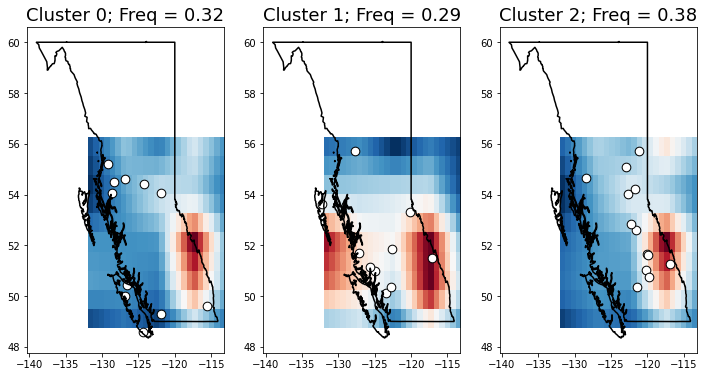

In [301]:
#visualize clusters

nrows = 1
ncols = n_clusters

vmin = np.min(cluster_patterns)
vmax = np.max(cluster_patterns)
plt.figure(figsize = (ncols*4,nrows*6))

for kk in range(n_clusters): #for each cluster
  cluster_pattern = cluster_patterns[kk,:]
  cluster_stations = np.squeeze(np.argwhere(labels==kk))
  cluster_stations = cluster_stations[cluster_stations<len(stationInds)]
  plt.subplot(nrows, ncols, kk+1)
  #plt.imshow(np.reshape(cluster_pattern, np.shape(heat_mean[0])), cmap = 'RdBu_r', vmin = vmin, vmax = vmax, extent = extentERA)
  plt.imshow(np.reshape(cluster_pattern, np.shape(heat_mean[0])), cmap = 'RdBu_r', extent = extentERA, aspect = 'auto')
  #plt.scatter(stationLon[stationInds[cluster_stations]], stationLat[stationInds[cluster_stations]], s = 75, facecolor = 'w', edgecolor = 'k')
  plt.scatter(stationLon[stationInds[cluster_stations]], stationLat[stationInds[cluster_stations]], s = 75, facecolor = 'w', edgecolor = 'k')
  plot_prov(prov = prov)
  plt.title('Cluster ' + str(kk) + '; Freq = ' + str(len(np.argwhere(labels==kk)) / len(labels))[:4], fontsize = 18)

plt.show()

In [163]:
cluster_stations

array([12, 13, 19, 24, 36, 37, 40, 41, 43, 45, 46, 47, 48, 49, 50, 52, 53,
       55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
       73, 74, 75, 76])

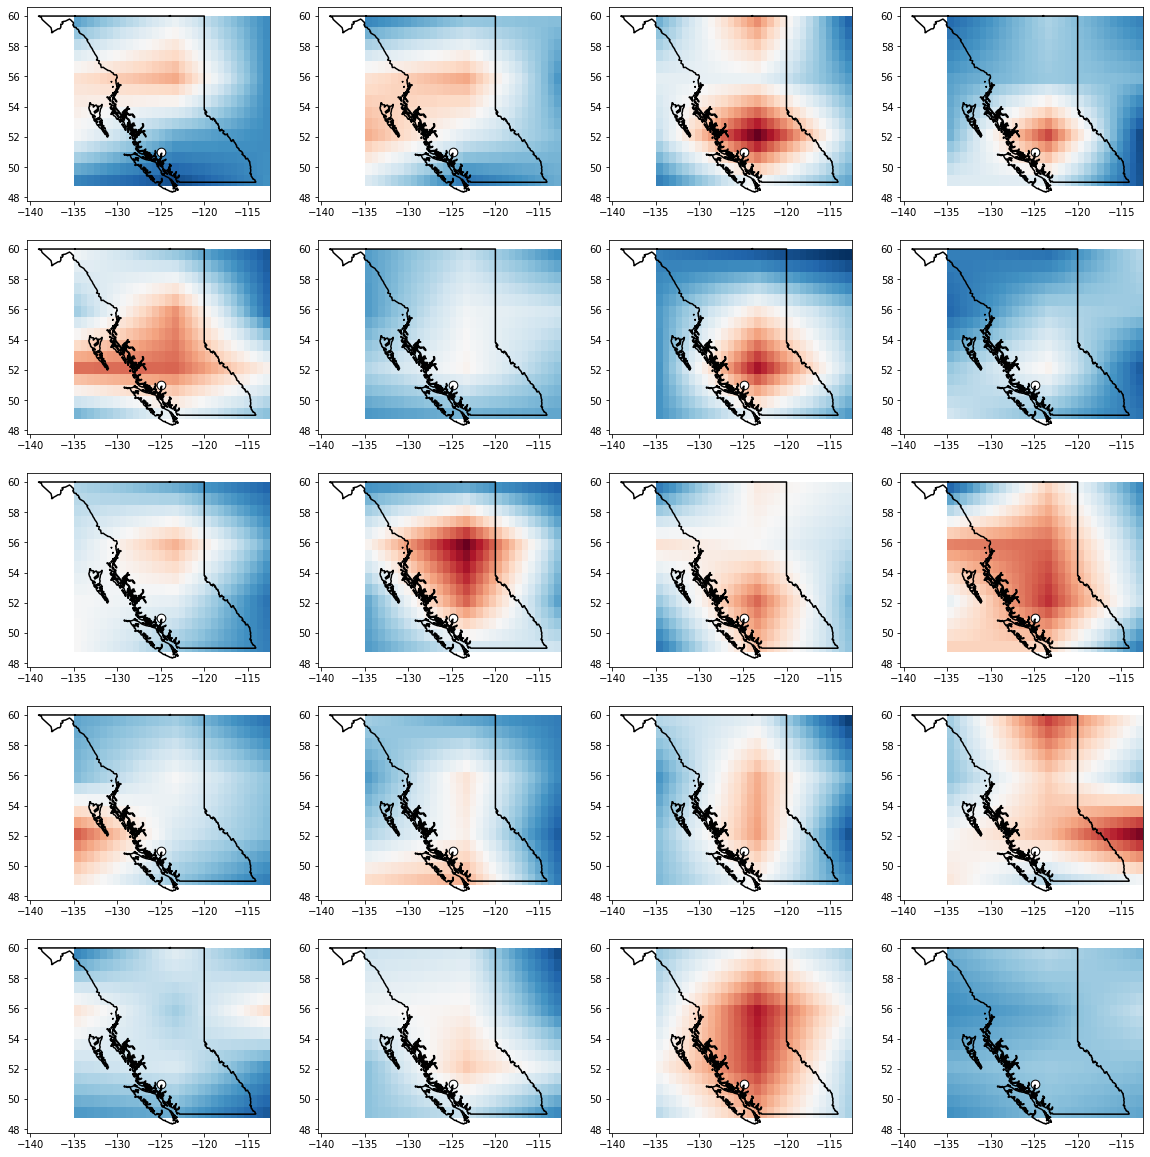

In [0]:
#visualize: where is the model sensitive each day?

plt.figure(figsize = (4*5,int(len(heat_days)/4)*5))

vmin = np.min(heat_days)
vmax = np.max(heat_days)

for kk in range(len(heat_days)):
  plt.subplot(int(len(heat_days)/4)+1,4,kk+1)
  plt.imshow(heat_days[kk], aspect = 'auto', cmap = 'RdBu_r', extent = extentERA, vmin = vmin, vmax = vmax)
  plot_prov(prov = prov)
  plt.scatter(stationLon[stationInds[station]],stationLat[stationInds[station]], facecolor = 'w', edgecolor = 'k', s = 75)

In [0]:
#cluster: what are the most characteristic "sensitivity days"?

data = np.asarray([np.squeeze(np.reshape(heat_day, (1,-1))) for heat_day in heat_days])
data_mean = data.mean(axis=1)
data_std = data.std(axis=1)
#data_norm = [(data[kk] - data_mean[kk]) / data_std[kk] for kk in range(len(data))]
data_norm = [data[kk] - data_mean[kk] for kk in range(len(data))]

n_clusters = 2
kmeans = KMeans(n_clusters = n_clusters).fit(data)
kmeans = KMeans(n_clusters = n_clusters).fit(data_norm)
labels = kmeans.labels_

#find mean pattern of each cluster
cluster_patterns = np.empty((n_clusters,np.shape(data)[1]))
for cluster_num in range(n_clusters):
    inds = np.argwhere(labels==cluster_num)
    cluster_patterns[cluster_num,:] = np.mean(data[inds,:],axis=0)
    
cluster_obs = np.empty((np.shape(data)))
for ind in range(len(data)):
    cluster_obs[ind] = cluster_patterns[labels[ind]]

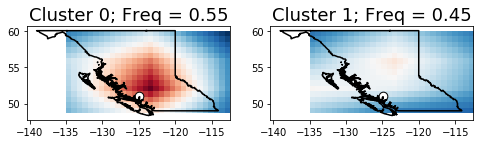

In [0]:
#visualize clusters

nrows = 1
ncols = n_clusters

vmin = np.min(cluster_patterns)
vmax = np.max(cluster_patterns)
plt.figure(figsize = (ncols*4,nrows*4))

for kk in range(n_clusters): #for each cluster
  cluster_pattern = cluster_patterns[kk,:]
  plt.subplot(nrows, ncols, kk+1)
  plt.imshow(np.reshape(cluster_pattern, np.shape(heat_days[0])), cmap = 'RdBu_r', vmin = vmin, vmax = vmax, extent = extentERA)
  plt.scatter(stationLon[stationInds[station]], stationLat[stationInds[station]], s = 75, facecolor = 'w', edgecolor = 'k')
  plot_prov(prov = prov)
  plt.title('Cluster ' + str(kk) + '; Freq = ' + str(len(np.argwhere(labels==kk)) / len(labels))[:4], fontsize = 18)

plt.show()

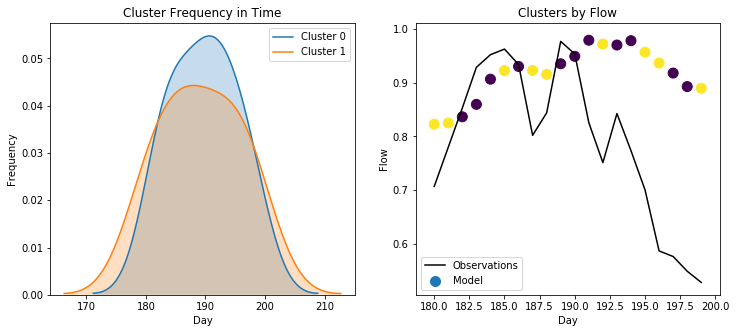

In [0]:
#visualize when clusters occur
plt.figure(figsize = (12,5))

plt.subplot(1,2,1)
for cluster in range(n_clusters):

  sns.kdeplot(data = [days[ind] for ind in np.argwhere(labels==cluster).ravel()], shade = True, label = 'Cluster '+str(cluster))

plt.legend()
plt.xlabel('Day')
plt.ylabel('Frequency')
plt.title('Cluster Frequency in Time')
#plt.show()

plt.subplot(1,2,2)
plt.plot(days, y_test[days,station],'k', label = 'Observations')
plt.scatter(days, y_test_predicted[days,station], c = labels, s = 100, label = 'Model')
plt.xlabel('Day')
plt.ylabel('Flow')
plt.title('Clusters by Flow')
plt.legend()

plt.show()


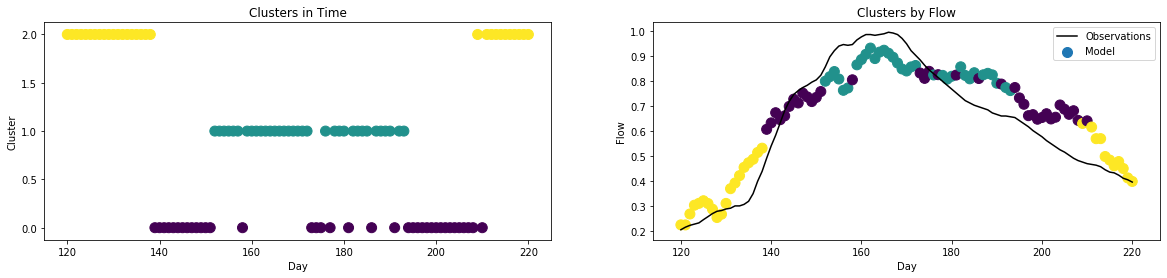

In [0]:
#visualize when clusters occur in time

plt.figure(figsize = (20,4))

plt.subplot(1,2,1)
plt.scatter(days, labels, c = labels, s = 100)
plt.xlabel('Day')
plt.ylabel('Cluster')
plt.title('Clusters in Time')

plt.subplot(1,2,2)
plt.plot(days, y_test[days,station],'k', label = 'Observations')
plt.scatter(days, y_test_predicted[days,station], c = labels, s = 100, label = 'Model')
plt.xlabel('Day')
plt.ylabel('Flow')
plt.title('Clusters by Flow')
plt.legend()

plt.show()

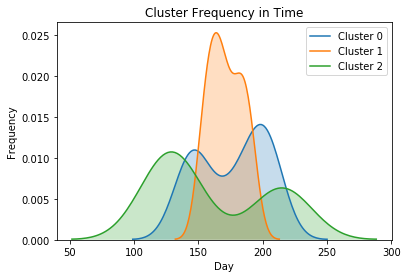

In [0]:
#visualize when clusters occur

import seaborn as sns

for cluster in range(n_clusters):

  sns.kdeplot(data = [days[ind] for ind in np.argwhere(labels==cluster).ravel()], shade = True, label = 'Cluster '+str(cluster))

plt.legend()
plt.xlabel('Day')
plt.ylabel('Frequency')
plt.title('Cluster Frequency in Time')
plt.show()

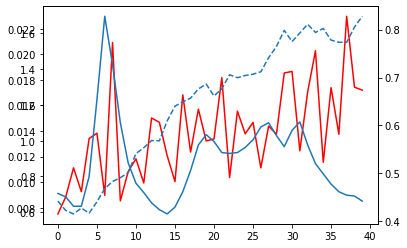

In [98]:
station = 11

fig, ax = plt.subplots()

ax.plot(heat_max[station], 'r')

ax1 = plt.twinx()
ax1.plot(y_test[days,station])

ax2 = plt.twinx()
ax2.plot(y_test_predicted[days,station], '--')

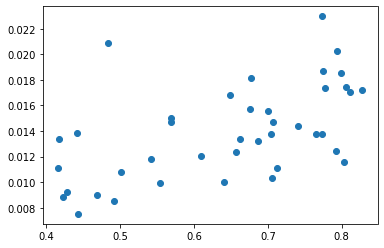

In [99]:
plt.scatter(y_test_predicted[days,station],heat_max[station])

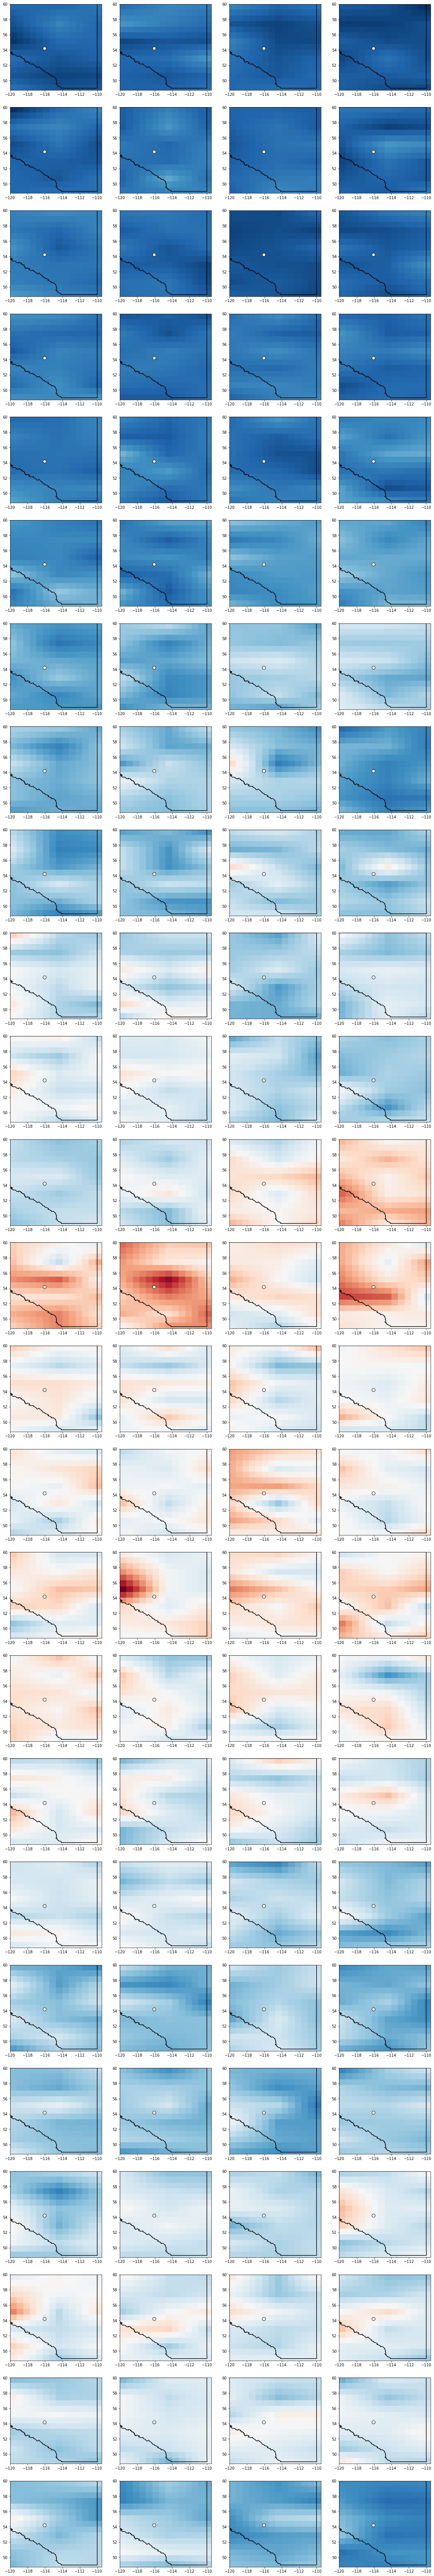

In [0]:
 plt.figure(figsize = (4*5,int(len(heat_days)/4)*5))

vmin = np.min(heat_days)
vmax = np.max(heat_days)

for kk in range(len(heat_days)):
  plt.subplot(int(len(heat_days)/4),4,kk+1)
  plt.imshow(heat_days[kk], aspect = 'auto', cmap = 'RdBu_r', extent = extentERA, vmin = vmin, vmax = vmax)
  plt.scatter(stationLon[stationInds[station]],stationLat[stationInds[station]], facecolor = 'w', edgecolor = 'k', s = 75)
  plot_AB()

# What is the model learning DURING training?

In [0]:
del Tmax, Tmin, P, H, S, x_lat, x_lon

In [0]:
del Tmaxnorm, Tminnorm, Pnorm, Hnorm, Snorm, x_lat_norm, x_lon_norm, Tall, Tmaxall, Tminall, Pall, Hall, Sall, x_lat_all, x_lon_all

In [0]:
def train_one_epoch(model, epochs, batch_size, xtrain, ytrain, es):
  
  history = model.fit(
            x_train, y_train,
            validation_split = 0.2,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1, 
            callbacks = [es],
          )
  
  return model

In [0]:
def make_heat(x_test, y_test, model, days_perturb, perturb_single_channel = False, channel_perturb = 0):
  
  iters_total = 50
  iters_one_pass = 50
  days = days_perturb #range(180,200) #number of days to perturb
  p_1 = 0.9 #probability of 1 in mask

  h = 3
  w = 3
  H = np.shape(x_test)[2]
  W = np.shape(x_test)[3]

  heat_all_slices = [[] for station in range(np.shape(y_test)[0])]
  heat_days = [[] for station in range(np.shape(y_test)[0])]
  jj = 0

  start = time.process_time()

  for day in days:

    print('Day ' + str(day) + '/' + str(days[-1]))

    for kk in range(int(iters_total/iters_one_pass)):

      print('   Iteration: ' + str(kk*iters_one_pass) + '/' + str(iters_total))

      iters = iters_one_pass

      x_int = np.arange(0,W+np.round(W/w) - 0.1,np.round(W/w))
      y_int = np.arange(0,H+np.round(H/h) - 0.1,np.round(H/h))
      xnew = np.arange(0,W,1)
      ynew = np.arange(0,H,1)

      mask_small = np.random.choice([0,1],size = (iters,1,h+1,w+1), p = [1-p_1,p_1])
      mask_large = np.half([interpolate.interp2d(x_int,y_int,mask_small[iter][0])(xnew,ynew) for iter in range(iters)])
      mask_large_2D = np.copy(mask_large)
      mask_large = np.repeat(np.expand_dims(np.asarray(mask_large),3),nchannels, axis = 3)
      mask_large = np.repeat(np.expand_dims(np.asarray(mask_large),1),365, axis = 1)

      if perturb_single_channel is True:
        for channel in range(nchannels):
          if channel != channel_perturb:
            mask_large[:,:,:,:,channel] = 1

      day_slice = [day]
      xday = x_test[day]
      xday_iters = np.asarray([xday for val in range(iters)])

      if perturb_single_channel is True:
        xday_iters_mask = xday_iters
        xday_iters_mask[:,:,:,:,channel_perturb] = np.multiply(xday_iters[:,:,:,:,channel_perturb],mask_large[:,:,:,:,channel_perturb])
      else: 
        xday_iters_mask = np.multiply(xday_iters,mask_large)

      x_all = np.squeeze(np.concatenate((np.expand_dims(xday, axis = 0),xday_iters_mask)))
      y_all = model.predict(x_all, batch_size = 128)

      yday = y_all[:len(day_slice)]
      yday_mask = y_all[len(day_slice):]

      for station in range(np.shape(y_all)[1]):
        yday_station = yday[:,station]
        yday_station_mask = yday_mask[:,station]

        ydiffs = np.abs(np.reshape([yday_station[jj] - yday_station_mask[jj*iters:jj*iters + iters] for jj in range(len(day_slice))],(-1,1)))
        delta = np.ones((len(ydiffs),H,W)) * ydiffs[:,None]
        heat_iters = [np.asarray(delta[jj*iters:(jj+1)*iters]) * (1 - np.asarray(mask_large_2D)) for jj in range(len(day_slice))]
        heat_iters = np.reshape(heat_iters,(len(day_slice)*iters,H,W))
        heat = [np.mean(heat_iters[jj*iters : (jj+1)*iters], axis=0) for jj in range(len(day_slice))] #fast
        
        heat_all_slices[station].append(heat[0]) #fast

      del heat, heat_iters, delta, ydiffs, x_all, xday_iters

    for station in range(np.shape(y_all)[1]):
      heat_days[station].append(np.mean(heat_all_slices[station][jj : jj + int(iters_total/iters_one_pass)], axis = 0))
    jj += int(iters_total/iters_one_pass)

  heat_mean = np.empty( (np.shape(y_all)[1] ,) + np.shape(np.mean(heat_all_slices[0],axis=0)) )
  heat_max = np.empty( (np.shape(y_all)[1] ,) + np.shape([np.max(heat_days[0][kk]) for kk in range(len(days))]))
  for station in range(np.shape(y_all)[1]):
    heat_mean[station] = np.mean(heat_all_slices[station],axis=0)
    heat_max[station] = [np.max(heat_days[station][kk]) for kk in range(len(days))]

  now = time.process_time() - start
  print(    str(now)[:6])

  return heat_mean

In [30]:
#define model
%tensorflow_version 2.x
import tensorflow
import tensorflow.keras
from tensorflow.keras import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, TimeDistributed, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

learning_rate = 0.0001

#CNN model
print('Building model...')
model = Sequential()

model.add(TimeDistributed(
    Conv2D(filters = 8, kernel_size = (3,3), activation='relu',data_format='channels_last', padding='same'), 
    input_shape=(365,)+np.shape(Tnorm[0])+(nchannels,)))

model.add(TimeDistributed(
    Conv2D(filters = 8, kernel_size = (3,3), activation='relu',data_format='channels_last', padding='same'), 
    input_shape=(365,)+np.shape(Tnorm[0])+(nchannels,)))

model.add(TimeDistributed(MaxPooling2D(pool_size = 2)))

model.add(TimeDistributed(
    Conv2D(filters = 16, kernel_size = (2,2), activation='relu',data_format='channels_last', padding='same'), 
    ))

model.add(TimeDistributed(
    Conv2D(filters = 16, kernel_size = (2,2), activation='relu',data_format='channels_last', padding='same'), 
    ))

model.add(TimeDistributed(MaxPooling2D(pool_size = 2)))

model.add(TimeDistributed(Flatten()))

model.add(Dropout(rate = 0.2))

model.add(LSTM(40, return_sequences=True))

model.add(Flatten())
model.add(Dense(np.shape(F)[1], activation = 'linear'))

#compile
print('Compiling model...')
model.compile(loss=tensorflow.keras.losses.MSE,
              optimizer=tensorflow.keras.optimizers.Adam(lr=learning_rate/10))

es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=1, 
                   patience = 3,
                   restore_best_weights = True)

model.summary()

TensorFlow 2.x selected.
Building model...
Compiling model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 365, 15, 30, 8)    368       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 365, 15, 30, 8)    584       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 365, 7, 15, 8)     0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 365, 7, 15, 16)    528       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 365, 7, 15, 16)    1040      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 365, 3, 7, 16)     0         
____________________________________________________________

In [31]:
epochs = 30
epochs_per_set = 10
epoch_sets = int(np.ceil((epochs - 2) / epochs_per_set)) + 2
heat_mean_epochs = []
days_perturb = range(180,200)
perturb_single_channel = False
channel_perturb = 2
batch_size = 128

for epoch_set in range(epoch_sets):
  
  if epoch_set == 0: #if first set, run zero epochs to get inital model sensitivity
    #model, history = train_one_epoch(model, 1, x_train, y_train, es)
    heat_mean = make_heat(x_test = x_test, y_test = y_test, model = model, days_perturb = days_perturb, perturb_single_channel = perturb_single_channel, channel_perturb = channel_perturb)
  elif epoch_set == 1: #if second set, run just 1 epoch 
    model = train_one_epoch(model, 1, batch_size, x_train, y_train, es)
    heat_mean = make_heat(x_test = x_test, y_test = y_test, model = model, days_perturb = days_perturb, perturb_single_channel = perturb_single_channel, channel_perturb = channel_perturb)
  else: #if after second set, run epochs_per_set and then recalculate sensitivity
    model = train_one_epoch(model, epochs_per_set, batch_size, x_train, y_train, es)
    heat_mean = make_heat(x_test = x_test, y_test = y_test, model = model, days_perturb = days_perturb, perturb_single_channel = perturb_single_channel, channel_perturb = channel_perturb)
    
  heat_mean_epochs.append(heat_mean)

Day 180/199
   Iteration: 0/50
Day 181/199
   Iteration: 0/50
Day 182/199
   Iteration: 0/50
Day 183/199
   Iteration: 0/50
Day 184/199
   Iteration: 0/50
Day 185/199
   Iteration: 0/50
Day 186/199
   Iteration: 0/50
Day 187/199
   Iteration: 0/50
Day 188/199
   Iteration: 0/50
Day 189/199
   Iteration: 0/50
Day 190/199
   Iteration: 0/50
Day 191/199
   Iteration: 0/50
Day 192/199
   Iteration: 0/50
Day 193/199
   Iteration: 0/50
Day 194/199
   Iteration: 0/50
Day 195/199
   Iteration: 0/50
Day 196/199
   Iteration: 0/50
Day 197/199
   Iteration: 0/50
Day 198/199
   Iteration: 0/50
Day 199/199
   Iteration: 0/50
17.536
Train on 5260 samples, validate on 1315 samples
5260/5260 [==============================] - 20s 4ms/sample - loss: 0.1499 - val_loss: 0.0855
Day 180/199
   Iteration: 0/50
Day 181/199
   Iteration: 0/50
Day 182/199
   Iteration: 0/50
Day 183/199
   Iteration: 0/50
Day 184/199
   Iteration: 0/50
Day 185/199
   Iteration: 0/50
Day 186/199
   Iteration: 0/50
Day 187/199
  

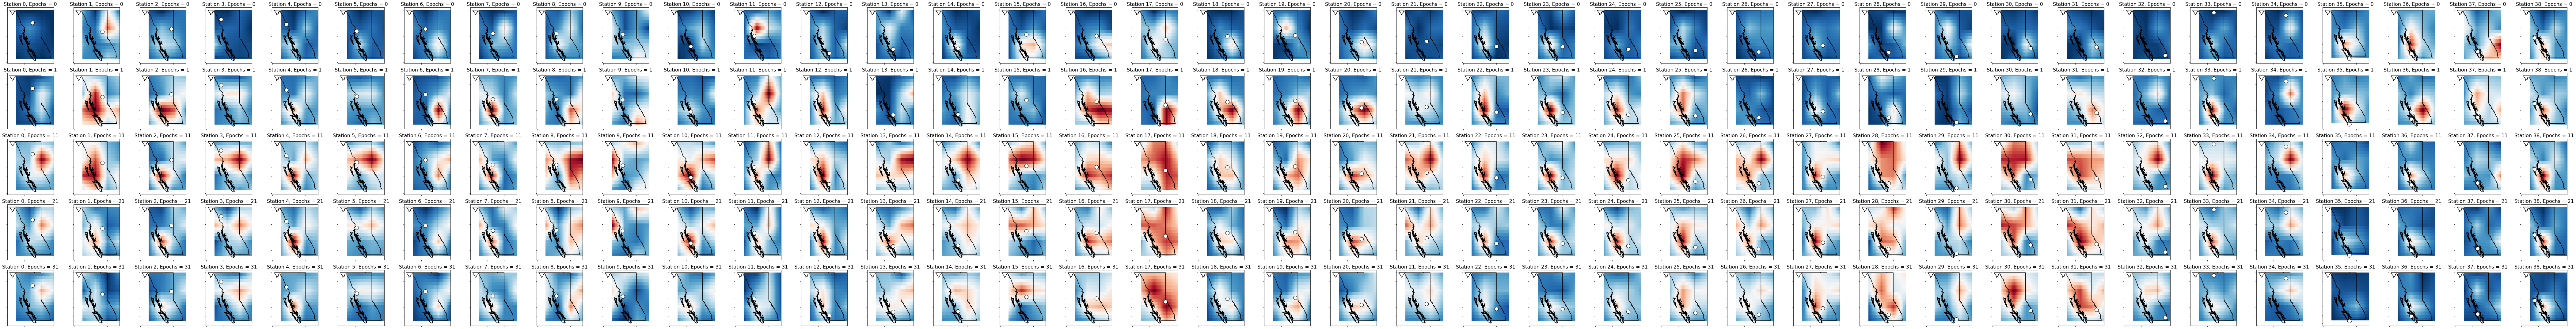

In [42]:
#visualize development of all heat maps: rows are epoch sets, columns are stations

saveIt = 0

vmax = [np.max(np.asarray(heat_mean_epochs)[:,ii,:,:]) for ii in range(len(stationInds))]
vmin = [np.min(np.asarray(heat_mean_epochs)[:,ii,:,:]) for ii in range(len(stationInds))]

columns = len(stationInds)
rows = epoch_sets

plt.figure(figsize = (columns*3, rows*3))

for column in range(columns): #for each column

  for row in range(rows):

    plt.subplot(rows, columns, column + row*columns + 1)
    plot_prov(prov = prov)
    plt.imshow(heat_mean_epochs[row][column],aspect='auto', cmap = 'RdBu_r',extent = extentERA, vmin = vmin[column], vmax = vmax[column])
    #plt.imshow(heat_mean_epochs[row][column],aspect='auto', cmap = 'RdBu_r',extent = extentERA)
    #plt.colorbar()
    plt.scatter(stationLon[stationInds[column]],stationLat[stationInds[column]], facecolor = 'w', edgecolor = 'k', s = 150, zOrder = 5)
    
    if row == 0:
      plt.title('Station ' + str(column) + ', Epochs = 0',fontsize = 16)
    elif row == 1:
      plt.title('Station ' + str(column) + ', Epochs = 1',fontsize = 16)
    else: 
      plt.title('Station ' + str(column) + ', Epochs = ' + str(1 + epochs_per_set * (row-1)), fontsize = 16)

    plt.tick_params(labelleft = None, labelbottom = None)

plt.tight_layout()

if saveIt:
  plt.savefig('model_focus.png')

In [0]:
#characterize heat maps in terms of their 'peakiness' and the distance from max heat to station as a function of epochs

d = np.empty((len(stationInds), epoch_sets)) #rows are stations, columns are epoch-sets
A = np.empty((len(stationInds), epoch_sets)) #rows are stations, columns are epoch-sets
peak = np.empty((len(stationInds), epoch_sets)) #rows are stations, columns are epoch-sets

for station in range(len(stationInds)): #for each station, find distance 'd' to max heat and area 'A' above half-max peak values

  for epoch_set in range(epoch_sets): #for each epoch_set, find distance 'd' to max heat and area 'A' above half-max peak values

    indLon = np.argmax(heat_mean_epochs[epoch_set][station], axis = 0)
    indLat = np.argmax(heat_mean_epochs[epoch_set][station], axis = 1)

    inds = np.where(heat_mean_epochs[epoch_set][station] == np.max(heat_mean_epochs[epoch_set][station]))
    indLat = inds[0]
    indLon = inds[1]

    d[station][epoch_set] = np.sqrt( (eraLat[indLat] - stationLat[stationInds[station]])**2 + (eraLon[indLon] - stationLon[stationInds[station]])**2 )

    halfMax = 0.5* (np.max(heat_mean_epochs[epoch_set][station]) - np.min(heat_mean_epochs[epoch_set][station]))
    A[station][epoch_set] = len(np.argwhere((heat_mean_epochs[epoch_set][station] - np.min(heat_mean_epochs[epoch_set][station])) > halfMax))

    peak[station][epoch_set] = np.max(heat_mean_epochs[epoch_set][station])


In [39]:
np.shape(heat_mean_epochs)

(5, 39, 15, 30)

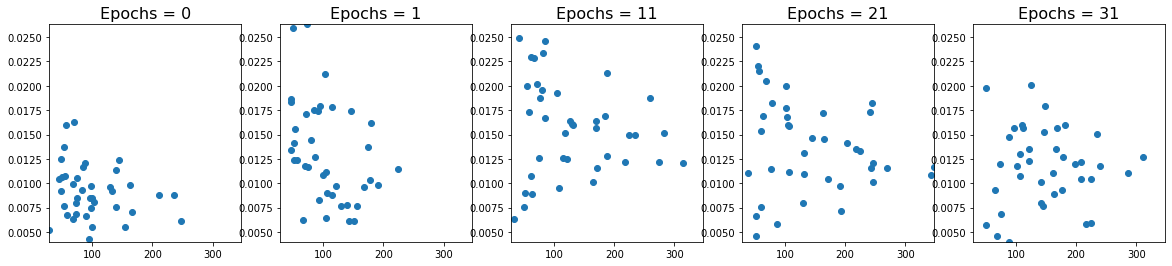

In [46]:
#visualize how model focus changes through training

plt.figure(figsize = (4*epoch_sets, 4))

for epoch_set in range(epoch_sets):

  x1 = A
  x2 = peak

  plt.subplot(1, epoch_sets, epoch_set + 1)
  plt.scatter(x1[:,epoch_set], x2[:,epoch_set])

  plt.xlim((np.min(x1), np.max(x1)))
  plt.ylim((np.min(x2), np.max(x2)))

  if epoch_set == 0:
    plt.title('Epochs = 0',fontsize = 16)
  elif epoch_set == 1:
    plt.title('Epochs = 1',fontsize = 16)
  else: 
    plt.title('Epochs = ' + str(1 + epochs_per_set * (epoch_set-1)), fontsize = 16)
  


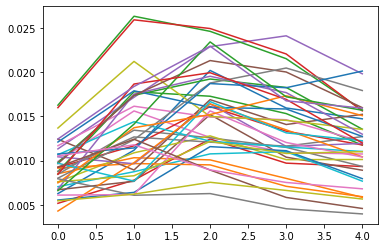

In [50]:
plt.plot(peak.T)
plt.show()

In [34]:
del x_train

NameError: ignored

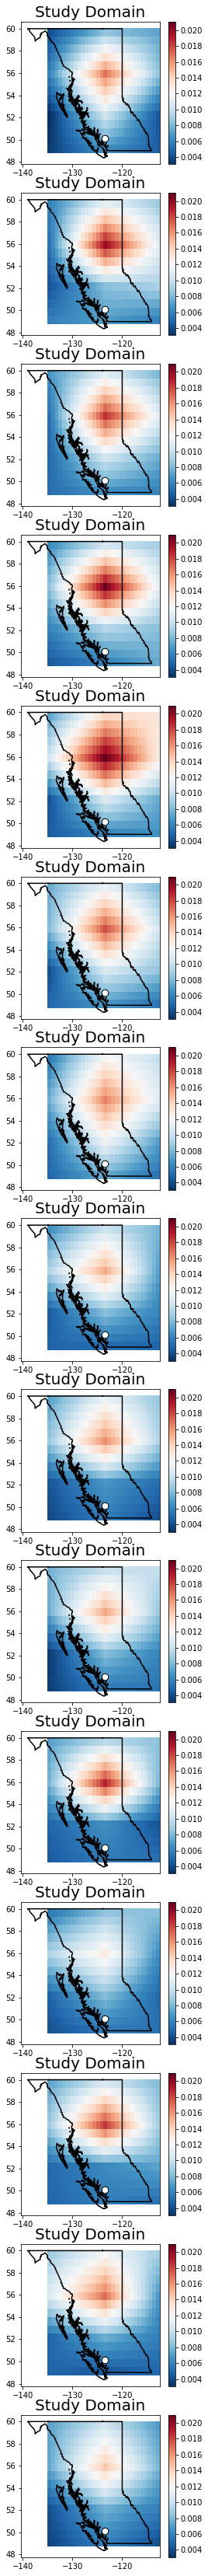

In [0]:
vmax = np.max(heat_mean_epochs)
vmin = np.min(heat_mean_epochs)

plt.figure(figsize = (4, 4*epoch_sets))

for epoch_set in range(epoch_sets):

  plt.subplot(epoch_sets, 1, epoch_set+1)
  plot_prov(prov = prov)
  plt.imshow(heat_mean_epochs[epoch_set],aspect='auto', cmap = 'RdBu_r',extent = extentERA, vmin = vmin, vmax = vmax)
  #plt.imshow(heat_mean_epochs[epoch_set],aspect='auto', cmap = 'RdBu_r',extent = extentERA)
  plt.colorbar()
  plt.scatter(stationLon[stationInds[station]],stationLat[stationInds[station]], facecolor = 'w', edgecolor = 'k', s = 75, zOrder = 5)
  plt.title('Study Domain',fontsize = 20)

# Fine tune on one station

In [0]:
#create input/output datasets

station_fine_tune = 1

#x is the same
y_fine_tune = y[:,station_fine_tune]
y_train_fine_tune = y_train[:,station_fine_tune]
y_test_fine_tune = y_test[:,station_fine_tune]

#y_fine_tune = y[:,station_fine_tune]
#y_train_fine_tune = y_train_dfdt[:,[station_fine_tune, station_fine_tune+39]]
#y_test_fine_tune = y_test_dfdt[:,[station_fine_tune, station_fine_tune+39]]
#y_fine_tune = np.vstack((y_train_fine_tune,y_test_fine_tune))

In [0]:
y_train_fine_tune2 = np.zeros((len(y_train_fine_tune),2))
y_train_fine_tune2[:,0] = y_train[:,station_fine_tune]
y_train_fine_tune2[1:,1] = y_train[1:,station_fine_tune] - y_train[:-1,station_fine_tune]
y_train_fine_tune2[:,1] = y_train_fine_tune2[:,1] *8


y_test_fine_tune2 = np.zeros((len(y_test_fine_tune),2))
y_test_fine_tune2[:,0] = y_test[:,station_fine_tune]
y_test_fine_tune2[1:,1] = y_test[1:,station_fine_tune] - y_test[:-1,station_fine_tune]
y_test_fine_tune2[:,1] = y_test_fine_tune2[:,1] *8

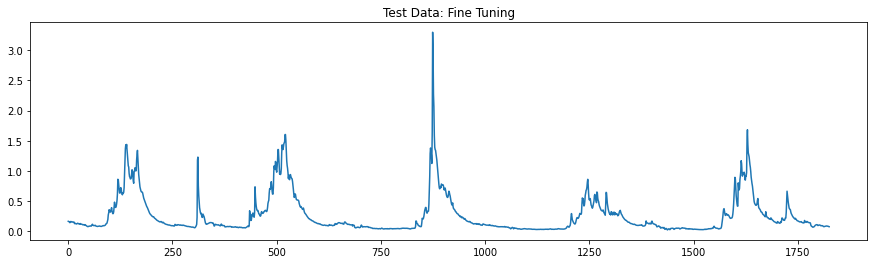

In [70]:
#visualize test data

plt.figure(figsize=(15,4))
plt.plot(y_test_fine_tune)
#plt.plot(y_test_fine_tune[:,1])
#plt.plot(y_test_predicted[:,station_fine_tune])
plt.title('Test Data: Fine Tuning')
plt.show()

In [0]:
#load model

loadModel = 0

if loadModel == 1:
  model = load_model('39_stations_LSTM_DO_LSTM_DENSE_20_epochs.h5')

In [0]:
def custom_loss(y_actual, y_predicted):
  loss = K.mean(K.abs((y_actual - y_predicted)**3))
  return loss

In [0]:
#THIS ONE WORKS Y'ALL
def custom_loss(y_train):

    # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
    def loss(y_true,y_pred):
        return K.mean(K.mean(K.square(y_pred - y_true)) + K.cast(K.mean(K.square(y_train)), dtype = 'float32'))
   
    # Return a function
    return loss

In [0]:
def custom_loss(y_train):

  def loss(y_actual, y_predicted):
 
    tensorflow.executing_eagerly()

    diff = K.abs(y_train - y_actual)
    #print(diff.numpy())
    sumdiff = K.sum(diff,axis = 1)
    #currInd = K.argmin(sumdiff).numpy()
    currInd = K.argmin(sumdiff)
    #print(currInd)
    #prevInd = K.eval(currInd-K.constant(1, dtype='int64'))
    
    prevInd = currInds - 1

    #prevInd = currInd-K.cast(1, dtype='int64')
    #prevInd = K.update_sub(currInd,1)

    #print(prevInd)
    #print(K.eval(prevInd))
    #print(K.get_value(prevInd))
    
    #y_actual_prev = y_train[K.get_value(prevInd)]
    #y_actual_prev = y_train[K.eval(prevInd)]
    #print(tensorflow.convert_to_tensor(y_train)[prevInd])
    y_actual_prev = K.cast(tensorflow.convert_to_tensor(y_train)[prevInd], dtype = 'float32')
    print(y_actual_prev)

    #print(y_actual_prev)
    dy_actual_dt_abs = K.abs(y_actual - y_actual_prev)
    #print(dy_actual_dt_abs)
    L = K.mean(K.abs((y_actual - y_predicted)**2) * dy_actual_dt_abs)

    #print(L)
    #print(K.abs((y_actual - y_predicted)**2) * dy_actual_dt_abs)
    #print(dy_actual_dt_abs)
    #print(y_actual_prev)
  

    return L

  return loss

In [71]:
#remove dense layer and add single connection

model_fine_tune = tensorflow.keras.models.clone_model(model)
model_fine_tune.set_weights(model.get_weights())

#store the post-LSTM layers
#FC= model_fine_tune.layers[-1]

#remove post-LSTM layers from model
model_fine_tune.pop() #remove Dense
#model_fine_tune.pop() #remove Flatten
#model_fine_tune.add(Dense(2, activation = 'linear'))
#model_fine_tune.add(LSTM(40, return_sequences=True))
#model_fine_tune.add(Flatten())
model_fine_tune.add(Dense(1, activation = 'linear'))

model_fine_tune.compile(loss=tensorflow.keras.losses.MSE,
            optimizer=tensorflow.keras.optimizers.Adam(lr=learning_rate))

#model_fine_tune.compile(loss=custom_loss,
#            optimizer=tensorflow.keras.optimizers.Adam(lr=learning_rate))

model_fine_tune.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 365, 15, 14, 16)   64        
_________________________________________________________________
time_distributed_1 (TimeDist (None, 365, 15, 14, 16)   272       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 365, 15, 14, 16)   2320      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 365, 15, 14, 16)   2320      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 365, 7, 7, 16)     0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 365, 7, 7, 32)     4640      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 365, 7, 7, 32)     9

In [77]:
#train model

trainModel = 1

if trainModel == 1:

  es = EarlyStopping(monitor='val_loss', 
                    mode='min', 
                    verbose=1, 
                    patience = 5)

  batch_size = 128
  epochs = 40
  history = model_fine_tune.fit(x_train,y_train_fine_tune, 
                      validation_split = 0.2, 
                      epochs = epochs, 
                      batch_size = batch_size,
                      verbose = 1, 
                      callbacks = [es])

Epoch 1/40
42/42 [==============================] - 16s 381ms/step - loss: 0.0473 - val_loss: 0.0943
Epoch 2/40
42/42 [==============================] - 16s 377ms/step - loss: 0.0471 - val_loss: 0.0930
Epoch 3/40
42/42 [==============================] - 16s 378ms/step - loss: 0.0469 - val_loss: 0.0949
Epoch 4/40
42/42 [==============================] - 16s 377ms/step - loss: 0.0465 - val_loss: 0.0947
Epoch 5/40
42/42 [==============================] - 16s 377ms/step - loss: 0.0469 - val_loss: 0.0966
Epoch 6/40
42/42 [==============================] - 16s 377ms/step - loss: 0.0462 - val_loss: 0.0951
Epoch 7/40
42/42 [==============================] - 16s 377ms/step - loss: 0.0464 - val_loss: 0.0946
Epoch 00007: early stopping


In [0]:
 #save model

saveModel = 0

if saveModel == 1:

  if glacierStations == 1:
    modelName = str(num_stations) + '_stations_' + 'LSTM_DO_LSTM_DENSE_glacierStations_' + str(epochs) + '_epochs_fine_tune'
    model.save(modelName + '.h5')
  else:
    modelName = str(num_stations) + '_stations_' + 'LSTM_DO_LSTM_DENSE_' + str(epochs) + '_epochs_fine_tune'
    model.save(modelName + '.h5')

In [0]:
#load model

loadModel = 0

if loadModel == 1:

  dataPath = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/'

  if glacierStations == 1:
    #modelName = str(num_stations) + '_stations_' + 'LSTM_DO_LSTM_DENSE_glacierStations_' + str(epochs) + '_epochs_fine_tune'
    modelName = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/18_stations_LSTM_DO_LSTM_DENSE_glacierStations_20_epochs_fine_tune'
    #model = load_model(dataPath + modelName + '.h5')
    model = load_model(modelName + '.h5')
  else:
    modelName = str(num_stations) + '_stations_' + 'LSTM_DO_LSTM_DENSE'
    model = load_model(dataPath + modelName + '.h5')

  #model = load_model(dataPath + str(num_stations) + '_stations_LSTM_DO_LSTM_DENSE.h5')

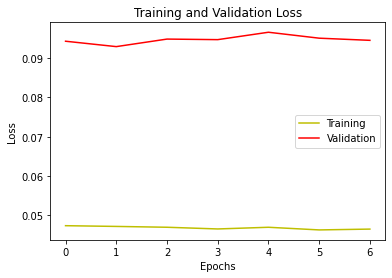

In [80]:
saveIt = 0

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(loss, 'y', label='Training')
plt.plot(val_loss, 'r', label='Validation')
plt.title('Training and Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.ylim((0,1))
#plt.show()

if saveIt:
  plt.savefig('loss.png')

In [82]:
#predict streamflow with trained model
#y_trainPredict = model.predict(x_train)
y_test_fine_tune_predict = model_fine_tune.predict(x_test, batch_size = 128, verbose = 1)
y_train_fine_tune_predict = model_fine_tune.predict(x_train, batch_size = 128, verbose = 1)

52/52 [==============================] - 6s 118ms/step


In [86]:
if predict_residuals:

  model_fine_tune_res = tensorflow.keras.models.clone_model(model_fine_tune)
  model_fine_tune_res.set_weights(model_fine_tune.get_weights())

  y_train_fine_tune_res = y_train_fine_tune - y_train_fine_tune_predict  
  y_test_fine_tune_res = y_test_fine_tune - y_train_fine_tune_predict 

  model_fine_tune_res.compile(loss=tensorflow.keras.losses.MSE,
            optimizer=tensorflow.keras.optimizers.Adam(lr=learning_rate))

  batch_size = 64
  epochs = 40
  history = model_fine_tune_res.fit(
              x_train, y_train_fine_tune_res,
              validation_split = 0.2,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1, 
              callbacks = [es],
            )

Epoch 1/40
83/83 [==============================] - 17s 210ms/step - loss: 0.3343 - val_loss: 0.2776
Epoch 2/40
83/83 [==============================] - 17s 203ms/step - loss: 0.2345 - val_loss: 0.2356
Epoch 3/40
83/83 [==============================] - 17s 203ms/step - loss: 0.2075 - val_loss: 0.2111
Epoch 4/40
83/83 [==============================] - 17s 203ms/step - loss: 0.1923 - val_loss: 0.1968
Epoch 5/40
83/83 [==============================] - 17s 203ms/step - loss: 0.1834 - val_loss: 0.1889
Epoch 6/40
83/83 [==============================] - 17s 203ms/step - loss: 0.1775 - val_loss: 0.1819
Epoch 7/40
83/83 [==============================] - 17s 204ms/step - loss: 0.1738 - val_loss: 0.1777
Epoch 8/40
83/83 [==============================] - 17s 203ms/step - loss: 0.1707 - val_loss: 0.1741
Epoch 9/40
83/83 [==============================] - 17s 203ms/step - loss: 0.1683 - val_loss: 0.1714
Epoch 10/40
83/83 [==============================] - 17s 203ms/step - loss: 0.1661 - val_lo

In [88]:
if predict_residuals:
  batch_size = 64
  epochs = 40
  history = model_fine_tune_res.fit(
              x_train, y_train_fine_tune_res,
              validation_split = 0.2,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1, 
              callbacks = [es],
            )


ResourceExhaustedError: ignored

In [90]:
if predict_residuals:
  y_test_fine_tune_res_predict = model_fine_tune_res.predict(x_test,batch_size = batch_size, verbose = 1)

29/29 [==============================] - 2s 63ms/step


In [0]:
y_test_fine_tune_predict = y_test_fine_tune_predict[:,0]

In [91]:
RMSE_bulk = rmse(target = y_test[:,station_fine_tune], prediction = y_test_predicted[:,station_fine_tune])
RMSE_fine_tune = rmse(target = y_test_fine_tune, prediction = y_test_fine_tune_predict)
RMSE_fine_tune_res = rmse(target = y_test_fine_tune, prediction = y_test_fine_tune_predict + y_test_fine_tune_res_predict)

print('RMSE Bulk = ' + str(RMSE_bulk)[:4])
print('RMSE Fine = ' + str(RMSE_fine_tune)[:4])

RMSE Bulk = 0.20
RMSE Fine = 0.21


In [92]:
RMSE_fine_tune_res

0.3244516371928521

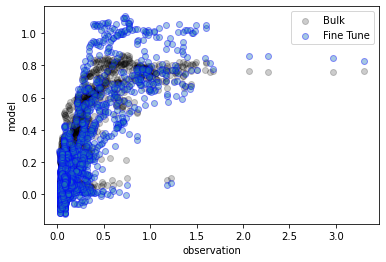

In [93]:
#visualize

saveIt = 0

plt.scatter(y_test[:,station_fine_tune],y_test_predicted[:,station_fine_tune],facecolor = 'k',alpha = 0.2)
plt.scatter(y_test_fine_tune,y_test_fine_tune_predict[:,0], alpha = 0.4, edgecolor = 'b')
plt.legend(('Bulk','Fine Tune'))
plt.xlabel('observation')
plt.ylabel('model')

if saveIt:
  plt.savefig('obs_vs_model.png')

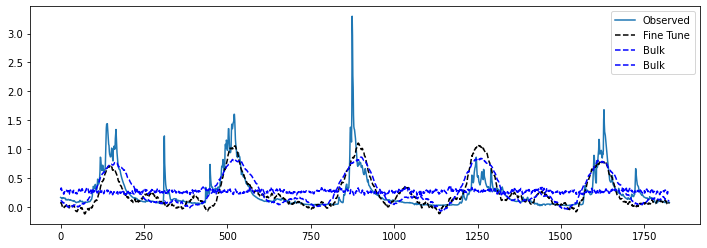

In [97]:
plt.figure(figsize = (12,4))
plt.plot(y_test_fine_tune, label = 'Observed')
plt.plot(y_test_fine_tune_predict[:,0],'k--', label = 'Fine Tune')
plt.plot(y_test_predicted[:,station_fine_tune],'b--', label = 'Bulk')

if predict_residuals:
  plt.plot(y_test_fine_tune_predict + y_test_fine_tune_res_predict,'b--', label = 'Bulk')

plt.legend()

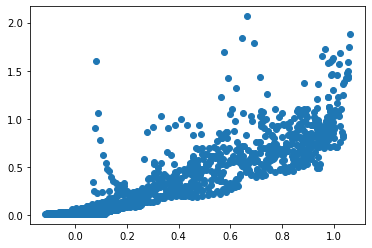

In [171]:
plt.scatter(y_test_fine_tune_predict, y_test_fine_tune)

In [172]:
#compute NSE

window = 366
stride = 365
NSE = nse(y_test_fine_tune,y_test_fine_tune_predict)
NSE_rolling = nse_rolling(y_test_fine_tune, y_test_fine_tune_predict, window = window, stride = stride)
print('NSE = ' + str(NSE)[:4])

NSE = 0.80


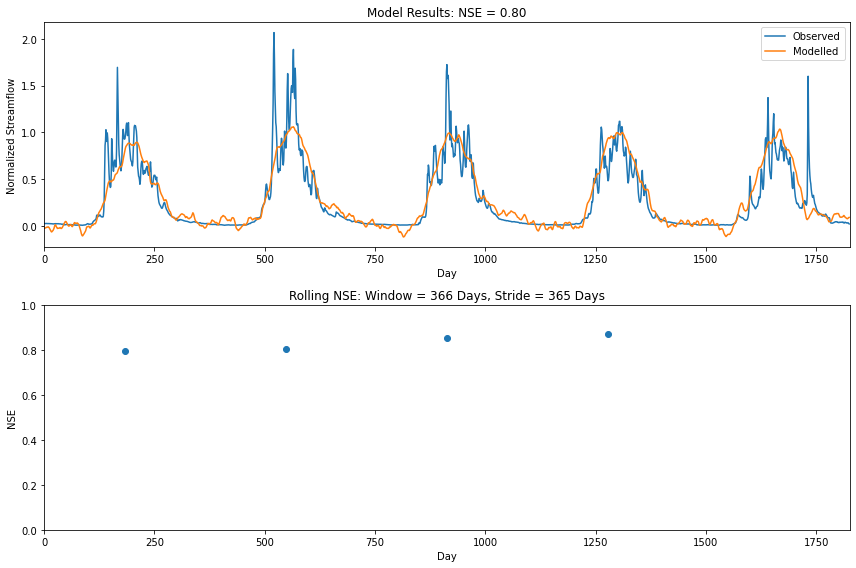

In [173]:
#visualize more

saveIt = 0

plt.figure(figsize = (12,8))

plt.subplot(2,1,1)
plt.plot(y_test_fine_tune, label = 'Observed')
plt.plot(y_test_fine_tune_predict, label = 'Modelled')
#plt.xlim((4500,6000))
plt.legend()
plt.xlabel('Day')
plt.ylabel('Normalized Streamflow')
plt.xlim((0,len(y_test_fine_tune)))
plt.title('Model Results: NSE = ' + str(NSE)[:4])

plt.subplot(2,1,2)
plt.scatter(range(int(window/2),len(y_test_fine_tune)-int(window/2), stride),NSE_rolling)
#plt.plot(NSE_rolling)
plt.ylim((0,1))
plt.xlim((0,len(y_test_fine_tune)))
plt.xlabel('Day')
plt.ylabel('NSE')
plt.title('Rolling NSE: Window = ' + str(window) + ' Days, Stride = ' + str(stride) + ' Days')

plt.tight_layout()

if saveIt:
  plt.savefig('modelled_time_series.png')

plt.show()

# What is the fine-tuned model learning?

In [174]:
#generate heat maps

iters_total = 100
iters_one_pass = 100
days = range(140,220) #number of days to perturb
station = station_fine_tune #station we're looking into
p_1 = 0.9 #probability of 1 in mask
perturb_single_channel = False #if true, only perturb one of the channels to see what it's looking at
channel_perturb = 2 #if perturb_single_channel is True, this is the channel to be perturbing

h = 4
w = 4
H = np.shape(x_test)[2]
W = np.shape(x_test)[3]

heat_all_slices = []
heat_days = []
heat_all_slices_bulk = []
heat_days_bulk = []
jj = 0

start = time.process_time()

for day in days:

  print('Day ' + str(day) + '/' + str(days[-1]))

  for kk in range(int(iters_total/iters_one_pass)):

    print('   Iteration: ' + str(kk*iters_one_pass) + '/' + str(iters_total))

    iters = iters_one_pass

    x_int = np.arange(0,W+np.round(W/w) - 0.1,np.round(W/w))
    y_int = np.arange(0,H+np.round(H/h) - 0.1,np.round(H/h))
    xnew = np.arange(0,W,1)
    ynew = np.arange(0,H,1)

    mask_small = np.random.choice([0,1],size = (iters,1,h+1,w+1), p = [1-p_1,p_1])
    mask_large = np.half([interpolate.interp2d(x_int,y_int,mask_small[iter][0])(xnew,ynew) for iter in range(iters)])
    mask_large_2D = np.copy(mask_large)
    mask_large = np.repeat(np.expand_dims(np.asarray(mask_large),3),nchannels, axis = 3)
    mask_large = np.repeat(np.expand_dims(np.asarray(mask_large),1),365, axis = 1)

    if perturb_single_channel is True:
      for channel in range(nchannels):
        if channel != channel_perturb:
          mask_large[:,:,:,:,channel] = 1

    day_slice = [day]
    xday = x_test[day]

    xday_iters = np.asarray([xday for val in range(iters)])

    if perturb_single_channel is True:
      xday_iters_mask = xday_iters
      xday_iters_mask[:,:,:,:,channel_perturb] = np.multiply(xday_iters[:,:,:,:,channel_perturb],mask_large[:,:,:,:,channel_perturb])
    else: 
      xday_iters_mask = np.multiply(xday_iters,mask_large)

    x_all = np.squeeze(np.concatenate((np.expand_dims(xday, axis = 0),xday_iters_mask)))
    y_all = model_fine_tune.predict(x_all, batch_size = 128)
    y_all_bulk = model_bulk.predict(x_all, batch_size = 128)

    yday = y_all[:len(day_slice)]
    yday_mask = y_all[len(day_slice):]

    yday_bulk = y_all_bulk[:len(day_slice)]
    yday_mask_bulk = y_all_bulk[len(day_slice):]

    yday_station = yday#[:,station]
    yday_station_mask = yday_mask#[:,station]

    yday_station_bulk = yday_bulk[:,station_fine_tune]
    yday_station_mask_bulk = yday_mask_bulk[:,station_fine_tune]

    ydiffs = np.abs(np.reshape([yday_station[jj] - yday_station_mask[jj*iters:jj*iters + iters] for jj in range(len(day_slice))],(-1,1)))
    delta = np.ones((len(ydiffs),H,W)) * ydiffs[:,None]
    heat_iters = [np.asarray(delta[jj*iters:(jj+1)*iters]) * (1 - np.asarray(mask_large_2D)) for jj in range(len(day_slice))]
    heat_iters = np.reshape(heat_iters,(len(day_slice)*iters,H,W))
    heat = [np.mean(heat_iters[jj*iters : (jj+1)*iters], axis=0) for jj in range(len(day_slice))] #fast
    heat_all_slices.append(heat[0]) #fast

    ydiffs = np.abs(np.reshape([yday_station_bulk[jj] - yday_station_mask_bulk[jj*iters:jj*iters + iters] for jj in range(len(day_slice))],(-1,1)))
    delta = np.ones((len(ydiffs),H,W)) * ydiffs[:,None]
    heat_iters = [np.asarray(delta[jj*iters:(jj+1)*iters]) * (1 - np.asarray(mask_large_2D)) for jj in range(len(day_slice))]
    heat_iters = np.reshape(heat_iters,(len(day_slice)*iters,H,W))
    heat_bulk = [np.mean(heat_iters[jj*iters : (jj+1)*iters], axis=0) for jj in range(len(day_slice))] #fast
    heat_all_slices_bulk.append(heat_bulk[0]) #fast

    del heat, heat_iters, delta, ydiffs, x_all, xday_iters

  heat_days.append(np.mean(heat_all_slices[jj : jj + int(iters_total/iters_one_pass)], axis = 0))
  heat_days_bulk.append(np.mean(heat_all_slices_bulk[jj : jj + int(iters_total/iters_one_pass)], axis = 0))
  jj += int(iters_total/iters_one_pass)

heat_mean = np.mean(heat_all_slices,axis=0)
heat_max = [np.max(heat_days[kk]) for kk in range(len(days))]

heat_mean_bulk = np.mean(heat_all_slices_bulk,axis=0)
heat_max_bulk = [np.max(heat_days_bulk[kk]) for kk in range(len(days))]

now = time.process_time() - start
print(    str(now)[:6])

Day 140/219
   Iteration: 0/100
Day 141/219
   Iteration: 0/100
Day 142/219
   Iteration: 0/100
Day 143/219
   Iteration: 0/100
Day 144/219
   Iteration: 0/100
Day 145/219
   Iteration: 0/100
Day 146/219
   Iteration: 0/100
Day 147/219
   Iteration: 0/100
Day 148/219
   Iteration: 0/100
Day 149/219
   Iteration: 0/100
Day 150/219
   Iteration: 0/100
Day 151/219
   Iteration: 0/100
Day 152/219
   Iteration: 0/100
Day 153/219
   Iteration: 0/100
Day 154/219
   Iteration: 0/100
Day 155/219
   Iteration: 0/100
Day 156/219
   Iteration: 0/100
Day 157/219
   Iteration: 0/100
Day 158/219
   Iteration: 0/100
Day 159/219
   Iteration: 0/100
Day 160/219
   Iteration: 0/100
Day 161/219
   Iteration: 0/100
Day 162/219
   Iteration: 0/100
Day 163/219
   Iteration: 0/100
Day 164/219
   Iteration: 0/100
Day 165/219
   Iteration: 0/100
Day 166/219
   Iteration: 0/100
Day 167/219
   Iteration: 0/100
Day 168/219
   Iteration: 0/100
Day 169/219
   Iteration: 0/100
Day 170/219
   Iteration: 0/100
Day 171/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: The following kwargs were not used by contour: 'aspect'
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: The following kwargs were not used by contour: 'aspect'


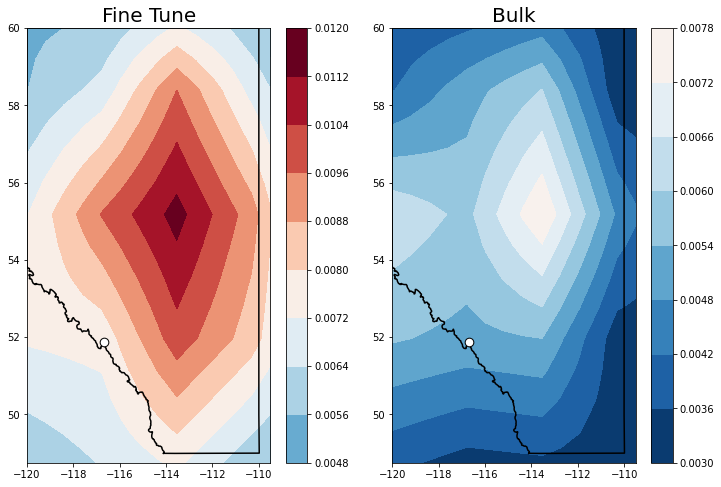

In [181]:
#visualize: where is the model most sensitive on average?

plt.figure(figsize = (12,8))

vmin = np.min([heat_mean, heat_mean_bulk])
vmax = np.max([heat_mean, heat_mean_bulk])

plt.subplot(1,2,1)
plot_prov(prov = prov)
plt.imshow(heat_mean,aspect='auto', cmap = 'RdBu_r',extent = extentERA, vmin = vmin, vmax = vmax)
plt.contourf(heat_mean,aspect='auto', cmap = 'RdBu_r',extent = extentERA, vmin = vmin, vmax = vmax)
plt.colorbar()
plt.scatter(stationLon[stationInds[station_fine_tune]],stationLat[stationInds[station_fine_tune]], facecolor = 'w', edgecolor = 'k', s = 75, zOrder = 5)
plt.title('Fine Tune',fontsize = 20)

plt.subplot(1,2,2)
plot_prov(prov = prov)
plt.imshow(heat_mean_bulk,aspect='auto', cmap = 'RdBu_r',extent = extentERA, vmin = vmin, vmax = vmax)
plt.contourf(heat_mean_bulk,aspect='auto', cmap = 'RdBu_r',extent = extentERA, vmin = vmin, vmax = vmax)
plt.colorbar()
plt.scatter(stationLon[stationInds[station_fine_tune]],stationLat[stationInds[station_fine_tune]], facecolor = 'w', edgecolor = 'k', s = 75, zOrder = 5)
plt.title('Bulk',fontsize = 20)

plt.show()

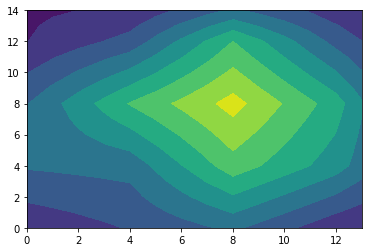

In [177]:
plt.contourf(heat_mean)

# What is the fine-tuned model learning DURING training?

# Fine tune on multiple stations

In [81]:
model_fine_tune = {} #empty dictionary; keys will be indices, objects will be models
y_fine_tune = {}
y_predict_fine_tune = {}
y_predict_bulk = {}

for station_fine_tune in range(2):#len(stationInds)):
  
  #create input/output datasets

  #x is the same
  y_fine_tune_current = y[:,station_fine_tune]
  y_train_fine_tune_current = y_train[:,station_fine_tune]
  y_test_fine_tune_current = y_test[:,station_fine_tune]

  #train model

  trainModel = 1

  if trainModel == 1:

    model_fine_tune_current = tensorflow.keras.models.clone_model(model)
    model_fine_tune_current.set_weights(model.get_weights())
    model_fine_tune_current.add(Dense(1, activation = 'linear'))

    model_fine_tune_current.compile(loss=tensorflow.keras.losses.MSE,
                optimizer=tensorflow.keras.optimizers.Adam(lr=learning_rate/10))

    es = EarlyStopping(monitor='val_loss', 
                      mode='min', 
                      verbose=1, 
                      patience = 1)

    batch_size = 32
    epochs = 20
    history = model_fine_tune_current.fit(x_train,y_train_fine_tune_current, 
                        validation_split = 0.2, 
                        epochs = epochs, 
                        batch_size = batch_size,
                        verbose = 1, 
                        callbacks = [es])
    
    model_fine_tune[station_fine_tune] = model_fine_tune_current
    y_fine_tune[station_fine_tune] = np.copy(y_fine_tune_current)
    y_predict_fine_tune[station_fine_tune] = model_fine_tune_current.predict(x, batch_size = batch_size, verbose = 1)
    y_predict_bulk[station_fine_tune] = model_bulk.predict(x, batch_size = batch_size, verbose = 1)

Train on 5260 samples, validate on 1315 samples
Epoch 1/20
5260/5260 [==============================] - 18s 3ms/sample - loss: 0.0646 - val_loss: 0.0488
Epoch 2/20
5260/5260 [==============================] - 16s 3ms/sample - loss: 0.0480 - val_loss: 0.0430
Epoch 3/20
5260/5260 [==============================] - 16s 3ms/sample - loss: 0.0437 - val_loss: 0.0390
Epoch 4/20
5260/5260 [==============================] - 16s 3ms/sample - loss: 0.0407 - val_loss: 0.0355
Epoch 5/20
5260/5260 [==============================] - 16s 3ms/sample - loss: 0.0385 - val_loss: 0.0333
Epoch 6/20
5260/5260 [==============================] - 16s 3ms/sample - loss: 0.0373 - val_loss: 0.0308
Epoch 7/20
5260/5260 [==============================] - 16s 3ms/sample - loss: 0.0353 - val_loss: 0.0290
Epoch 8/20
5260/5260 [==============================] - 16s 3ms/sample - loss: 0.0339 - val_loss: 0.0287
Epoch 9/20
5260/5260 [==============================] - 16s 3ms/sample - loss: 0.0322 - val_loss: 0.0278
Epoch 1

ValueError: ignored

In [0]:
#Evaluate performance of fine-tuned models vs bulk models

NSE_fine_tune = []
NSE_series_fine_tune = []

NSE_bulk = []
NSE_series_bulk = []

for ind in range(len(y_predict_fine_tune)):

  y_obs = y_fine_tune[ind]
  y_model = y_predict_fine_tune[ind]

  window = 365
  stride = 366

  NSE_fine_tune.append(nse(y_obs = y_obs, y_model = y_model))
  NSE_series_fine_tune.append(nse_rolling(y_obs = y_obs, y_model = y_model, window = window, stride = stride))

  y_obs = y_fine_tune[ind]
  y_model = y_predict_bulk[ind]

  window = 365
  stride = 366

  NSE_bulk.append(nse(y_obs = y_obs, y_model = y_model))
  NSE_series_bulk.append(nse_rolling(y_obs = y_obs, y_model = y_model, window = window, stride = stride))

(2000, 3000)

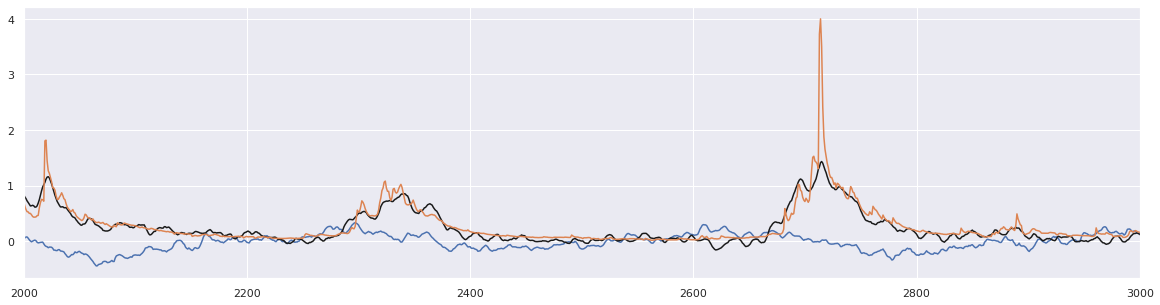

In [0]:
plt.figure(figsize = (20,5))

ind = 1
plt.plot(y_predict_bulk[ind])
plt.plot(y_predict_fine_tune[ind], color = 'k')
plt.plot(y_fine_tune[ind])

plt.xlim((2000,3000))

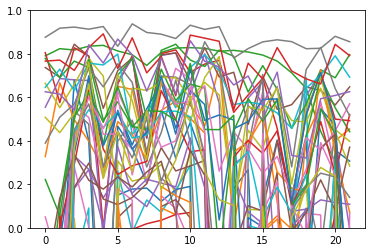

In [0]:
plt.plot(np.asarray(NSE_series_fine_tune).T)
plt.ylim((0,1))
plt.show()

Text(0.5, 1.0, 'Mean NSE')

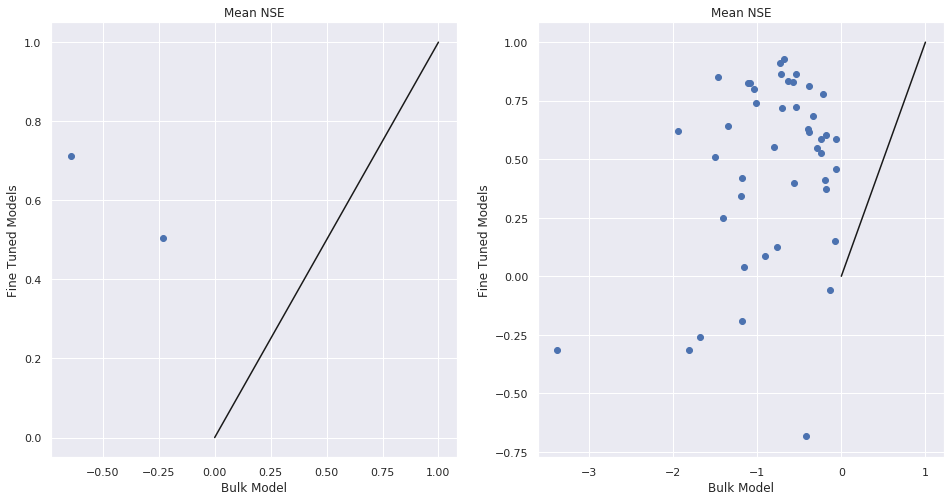

In [0]:
#scatter fine vs bulk NSE

xline = [0,1]

plt.figure(figsize = (16,8))

plt.subplot(1,2,1)
plt.scatter(NSE_bulk, NSE_fine_tune)
plt.plot(xline,xline,color = 'k')
plt.xlabel('Bulk Model')
plt.ylabel('Fine Tuned Models')
#plt.xlim((0,1))
#plt.ylim((0,1))
plt.title('Mean NSE')

plt.subplot(1,2,2)
plt.scatter(np.reshape(NSE_series_bulk,(-1,1)), np.reshape(NSE_series_fine_tune,(-1,1)))
plt.plot(xline,xline,color = 'k')
plt.xlabel('Bulk Model')
plt.ylabel('Fine Tuned Models')
#plt.xlim((0,1))
#plt.ylim((0,1))
plt.title('Mean NSE')